# dependencies
* install anaconda is recommended

```
cassandra-driver          3.11.0                   py35_1    conda-forge
pandas                    0.19.1              np111py35_0
scikit-learn              0.18.1              np111py35_0
scipy                     0.18.1              np111py35_0
matplotlib                2.0.0               np111py35_0
```

In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100


In [4]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-BPR"

start_date = '2019-01-01'
end_date = '2019-03-31'
# site_ids = ['adbehap']
# site_ids = ['avast', 'kasperus', 'adbehap', 'adbehbr', 'adbehkr', 'mcafeeus', 'mfeap', 'mfeeu']
# desc = str('%s_%s_%s' % (start_date, end_date, "_".join(site_ids)))
# desc = '%s_%s_All_sites'.format(start_date, end_date)
# desc = '%s_%s_for_processor_retry'.format(start_date, end_date)

In [5]:
# from cassandra
from cassandra.cluster import Cluster
cassandra_endpoint = '10.62.1.118'
# cassandra_endpoint = '10.224.12.42'
cluster = Cluster([cassandra_endpoint])


In [6]:
# retry_success =  pd.read_csv(WORK_DIR + 'retry_success_processor_attempt_with_bin_01_to_12.csv')
# retry_success =  pd.read_csv(WORK_DIR + 'processor_retry_01_to_12.csv')
retry_success =  pd.read_csv(WORK_DIR + 'processor_retry_2019_01_to_03.csv')
retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1930717, 58)

In [5]:
retry_success_2019 =  pd.read_csv(WORK_DIR + 'processor_retry_2019_01_to_02.csv')
retry_success_2019.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1026467, 57)

In [11]:
retry_success['success'].value_counts(normalize=True)

0    0.983291
1    0.016709
Name: success, dtype: float64

In [10]:
retry_success['failed_cid'].value_counts(dropna=False)

NaN                 1825150
RETRY_DECLINED.2     102358
RETRY_FAILED.2         2914
RETRY_FAILED.3          219
payerID                  35
RETRY_FAILED.4           34
RETRY_DECLINED.3          7
Name: failed_cid, dtype: int64

In [78]:
retry_success['failed_decline_type'].value_counts(dropna=False)

txn_refused                            2418027
do_not_honor                           1061455
declined                               1038097
Insufficient Funds                      828560
Hard Fraud                              482290
Base                                    383638
insufficient funds                      163852
expired_card                            131063
correct_cc_retry                         86607
invalid_cc                               40752
invalid_txn                              20163
blocked_first_used                       18053
no charge model found                     6871
corrupt input data                        6375
not_permitted                             6145
server error                              5659
acquirer error                            5219
do_not_try_merchant_review                4685
transaction refused[30]                   4175
invalid_account                           3812
litle http response code                  2933
no reply     

In [6]:
retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_response_code,failed_response_message,failed_decline_type,failed_event_uuid,failed_cc_expiration_date,expiration_date_changed,processor_mid_changed,failed_cid,failed_payment_service_id,failed_merchant_number,processor_att_num
0,0,2019-02-03,avast,10007475401,8230718493,2019-02-03 14:38:20,2.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770.0,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0420,RETRY_DECLINED.2,2.0,3,sunday,af5fedf6-62f6-489c-8fea-4a72b5c2e97b,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,114.700000,EUR,MasterCard,netgiro-bms,1,99.99,114.700000,EUR,57531456100,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-03 08:38:20,8,Authorize,0,530.0,Refused: Refused,txn_refused,d9683bf6-9d95-416e-9e46-a02a7b237bb0,0420,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2
1,1,2019-02-08,avast,10007475401,8258737853,2019-02-08 12:15:40,0.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770.0,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0418,RETRY_DECLINED.2,0.0,8,friday,840199bd-00a6-426d-aa44-e4a155f48067,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,113.440000,EUR,MasterCard,netgiro-bms,2,99.99,113.440000,EUR,57730537600,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-08 06:15:40,6,Authorize,0,522.0,05: Do not honor,do_not_honor,efae77a9-9eba-47eb-8200-d3d235f2424a,0418,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2
2,2,2019-03-07,adbehkr,10059085901,8421456683,2019-03-07 06:41:52,NaN,NON3DS,"HYUNDAICARD CO., LTD.",KR,552290.0,MasterCard,World MasterCard Card,Consumer,Credit - True credit (No PIN/Signature capability),0922,RETRY_DECLINED.2,NaN,7,thursday,ade6ea11-11c1-4d9a-9e52-60bc4ed4c6fd,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.800000,KRW,MasterCard,netgiro-bms,1,11000.00,9.800000,KRW,58876377200,27050.0,Do not try again/use alternate payment card.[62] [] [144800] [144800],New,18805274000,2019-03-07 00:41:52,0,Authorize,0,27001.0,Transaction refused[62] [000000] [] [],Hard Fraud,27c2e03c-15c5-4b43-a222-c40f65023c1f,0922,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2
3,3,2019-01-11,adbehkr,10076134701,8095353453,2019-01-11 06:40:54,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842.0,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221,RETRY_DECLINED.2,NaN,11,friday,ce3cb7bb-0bdc-4552-9485-fb2f978cd68b,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.843372,KRW,Visa,netgiro-bms,1,11000.00,9.843372,KRW,56551670600,27001.0,Transaction refused[05] [] [111800] [111800],New,18181256200,2019-01-11 00:40:54,0,Authorize,0,27001.0,Transaction refused[05] [000000] [] [],txn_refused,2faa2dd5-13e0-4f30-9daa-ae74bafb81f2,0221,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2
4,4,2019-01-18,adbehkr,10076134701,8137731603,2019-01-18 06:52:14,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842.0,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221

In [9]:
retry_success = retry_success[retry_success['days_between'] == 0]
retry_success.shape

(6733181, 62)

In [29]:
# FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']
FEATURES_FLOAT = ['bin']

def handle_feat_float(df):
        for feat in FEATURES_FLOAT:
            if feat in FEATURES_FLOAT:
                df[feat] = df[feat].fillna('').apply(str).str.replace('.0', '', regex=False)
        return df

handle_feat_float(retry_success)    
# handle_feat_float(retry_success_2019)   

retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_response_code,failed_response_message,failed_decline_type,failed_event_uuid,failed_cc_expiration_date,expiration_date_changed,processor_mid_changed,failed_cid,failed_payment_service_id,failed_merchant_number,processor_att_num,Mean,Median,Min,Max,StdDev,Max_95,Max_99,Min_1,mean_diff,median_diff,max_99_diff,std_diff
0,0,2019-02-03,avast,10007475401,8230718493,2019-02-03 14:38:20,2.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0420,RETRY_DECLINED.2,2.0,3,sunday,af5fedf6-62f6-489c-8fea-4a72b5c2e97b,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,114.700000,EUR,MasterCard,netgiro-bms,1,99.99,114.700000,EUR,57531456100,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-03 08:38:20,8,Authorize,0,530.0,Refused: Refused,txn_refused,d9683bf6-9d95-416e-9e46-a02a7b237bb0,0420,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-02-08,avast,10007475401,8258737853,2019-02-08 12:15:40,0.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0418,RETRY_DECLINED.2,0.0,8,friday,840199bd-00a6-426d-aa44-e4a155f48067,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,113.440000,EUR,MasterCard,netgiro-bms,2,99.99,113.440000,EUR,57730537600,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-08 06:15:40,6,Authorize,0,522.0,05: Do not honor,do_not_honor,efae77a9-9eba-47eb-8200-d3d235f2424a,0418,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-03-07,adbehkr,10059085901,8421456683,2019-03-07 06:41:52,NaN,NON3DS,"HYUNDAICARD CO., LTD.",KR,552290,MasterCard,World MasterCard Card,Consumer,Credit - True credit (No PIN/Signature capability),0922,RETRY_DECLINED.2,NaN,7,thursday,ade6ea11-11c1-4d9a-9e52-60bc4ed4c6fd,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.800000,KRW,MasterCard,netgiro-bms,1,11000.00,9.800000,KRW,58876377200,27050.0,Do not try again/use alternate payment card.[62] [] [144800] [144800],New,18805274000,2019-03-07 00:41:52,0,Authorize,0,27001.0,Transaction refused[62] [000000] [] [],Hard Fraud,27c2e03c-15c5-4b43-a222-c40f65023c1f,0922,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-11,adbehkr,10076134701,8095353453,2019-01-11 06:40:54,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221,RETRY_DECLINED.2,NaN,11,friday,ce3cb7bb-0bdc-4552-9485-fb2f978cd68b,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.843372,KRW,Visa,netgiro-bms,1,11000.00,9.843372,KRW,56551670600,27001.0,Transaction refused[05] [] [111800] [111800],New,18181256200,2019-01-11 00:40:54,0,Authorize,0,27001.0,Transaction refused[05] [000000] [] [],txn_refused,2faa2dd5-13e0-4f30-9daa-ae74bafb81f2,0221,False,processor_changed_mi

In [24]:
bin_profile = pd.read_csv(WORK_DIR + 'bin_profile.csv')
bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
bin_profile.shape

(38193, 12)

In [12]:
bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
bin_profile.head()

,Unnamed: 0,bin,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1,Min_10,count
0,0,,24.619604,0.011639,3460.000000,83.243053,84.790000,114.160000,4.605657,4.605657,3992
1,1,230540,21.084444,6.990000,46.800000,11.484375,41.640500,45.768100,9.370000,9.370000,18
2,6,352818,17.592826,4.800000,51.479167,17.392817,42.803542,49.744042,4.800000,4.800000,10
3,7,352820,41.598632,30.700000,73.000000,17.923461,66.380000,71.676000,31.100000,31.100000,5
4,8,352821,49.015144,48.102689,50.518630,0.988569,50.246824,50.464269,48.115695,48.115695,5


In [51]:
# bin_profile.to_csv(WORK_DIR + 'bin_profile_2018_01_to_2019_03.csv')

In [8]:
retry_success['bin'] = retry_success['bin'].fillna('')

In [35]:
### resampling, balancing classes ###
def balancing_class(df_ml):
    print(df_ml[LABEL].value_counts(normalize=True))
    df_cls_0 = df_ml[df_ml[LABEL] == 0]
    df_cls_1 = df_ml[df_ml[LABEL] == 1]

    #over sampling
# #     df_cls_0_over = df_cls_0.sample(len(df_cls_1), replace=True)
# #     df_ml_bl = pd.concat([df_cls_0_over, df_cls_1], axis=0)
    df_cls_1_over = df_cls_1.sample(len(df_cls_0), replace=True)
    df_ml_bl = pd.concat([df_cls_1_over, df_cls_0], axis=0, ignore_index=False)

#     #under sampling
#     df_cls_1_under = df_cls_1.sample(len(df_cls_0), replace=True)
#     df_ml_bl = pd.concat([df_cls_1_under, df_cls_0], axis=0)
#     df_cls_0_under = df_cls_0.sample(len(df_cls_1), replace=True)
#     df_ml_bl = pd.concat([df_cls_0_under, df_cls_1], axis=0)
    
    print(df_ml_bl[LABEL].value_counts(normalize=True))
    print(df_ml_bl.shape)
    return df_ml_bl

In [36]:
retry_success_balanced_all = balancing_class(retry_success)
# csv_name = str('subs_retry_balanced__%s_%s_%s.csv' % (start_date, end_date, "_".join(site_ids)))
# retry_success_balanced_all.to_csv(WORK_DIR + csv_name)
# print("Saved into " + WORK_DIR + csv_name)
# retry_success_balanced_all.shape

0    0.804565
1    0.195435
Name: success, dtype: float64
1    0.5
0    0.5
Name: success, dtype: float64
(8994644, 61)


In [58]:
# retry_success_balanced_all = retry_success_balanced_all.drop('Unnamed: 0', axis=1)
# retry_success_balanced_all.head()
# retry_success.drop(['Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1'], axis=1, inplace=True)

In [10]:
original_size = len(retry_success)
# balanced_size = len(retry_success_balanced_all)
fail_size = retry_success[LABEL].value_counts(normalize=True)[0.0]
success_size =  retry_success[LABEL].value_counts(normalize=True)[1.0]

In [11]:
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn import tree
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
from sklearn import cross_validation

def print_accuracy_report(classifier, X, y, num_validations=5):
    accuracy = cross_validation.cross_val_score(classifier, 
            X, y, scoring='accuracy', cv=num_validations)
    print("CV Accuracy: " + str(round(100*accuracy.mean(), 2)) + "%")

    f1 = cross_validation.cross_val_score(classifier, 
            X, y, scoring='f1_weighted', cv=num_validations)
    print("CV F1: " + str(round(100*f1.mean(), 2)) + "%")

    precision = cross_validation.cross_val_score(classifier, 
            X, y, scoring='precision_weighted', cv=num_validations)
    print("CV Precision: " + str(round(100*precision.mean(), 2)) + "%")

    recall = cross_validation.cross_val_score(classifier, 
            X, y, scoring='recall_weighted', cv=num_validations)
    print("CV Recall: " + str(round(100*recall.mean(), 2)) + "%")

In [13]:
%set_env SPARK_HOME=/opt/spark
from src.web.preprocessing import PreProcessing
import os
import findspark
os.environ['PYSPARK_SUBMIT_ARGS'] = """\
--master spark://10.62.42.243:7077 
--packages datastax:spark-cassandra-connector:2.3.1-s_2.11,anguenot:pyspark-cassandra:0.9.0
--driver-memory 43g
--executor-memory 30g
--conf spark.local.dir=/var/spark
--conf spark.network.timeout=420000
--conf spark.shuffle.registration.timeout=42000
--conf spark.driver.maxResultSize=43
--conf spark.files.overwrite=true
--conf num-executors=5
--py-files src3.zip
pyspark-shell
"""

# --py-files src.zip
# --conf spark.cores.max=32
# --conf spark.driver.cores=6
# --conf spark.executor.cores=8

import pyspark
from pyspark import SparkContext, SparkConf
findspark.init()
sc = pyspark.SparkContext(appName="BestCalendarAttemptTraining")
sc._conf.set("spark.sql.execution.arrow.enabled", "true")
sc._conf.set('spark.driver.maxResultSize', '43')
sc._conf.set('spark.driver.cores', '6')
sc._conf.set('spark.executor.cores', '8')

# sc._conf.set("spark.cores.max", 6)
sc._conf.set("spark.local.dir", "/var/spark")
sc._conf.set("spark.files.overwrite", True)
# sc.addPyFile("src.zip")
sc.addFile('src3.zip')

sc.addPyFile('src/web/encoder.py')
sc.addPyFile('src/web/preprocessing.py')
sc.addPyFile('src/web/utils.py')

sc

env: SPARK_HOME=/opt/spark


<SparkContext master=spark://10.62.42.243:7077 appName=BestCalendarAttemptTraining>

In [12]:
INPUT_FEATURES = {
            "billing_country": {
                "type": "string"
            },
            "bin": {
                "type": "string"
            },
            "card_brand": {
                "type": "string"
            },
            "card_category": {
                "type": "string"
            },
            "card_class": {
                "type": "string"
            },
            "card_usage": {
                "type": "string"
            },
            "cc_expiration_date": {
                "type": "string"
            },
            "day_of_month": {
                "type": "integer"
            },
            "failed_attempt_date": {
                "type": "string"
            },
            "failed_response_code": {
                "type": "string"
            },
            "failed_response_message": {
                "type": "string"
            },
            "funding_source": {
                "type": "string"
            },
            "issuer_country": {
                "type": "string"
            },
            "merchant_number": {
                "type": "string"
            },
            "payment_amount_usd": {
                "type": "number"
            },
            "payment_currency": {
                "type": "string"
            },
            "payment_method_id": {
                "type": "string"
            },
            "payment_service_id": {
                "type": "string"
            },
            "renew_att_num": {
                "type": "string"
            },
            "site_id": {
                "type": "string"
            },
            "transaction_date_in_string": {
                "type": "string"
            },
            "failed_cid": {
                "type": "string"
            },
            "failed_payment_service_id": {
                "type": "string"
            },
            "failed_merchant_number": {
                "type": "string"
            }
        }

####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
# fit_time: 102.56088829040527
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message'],
              drop_invariant=False, handle_unknown='ignore',
              impute_missing=False, random_state=None, randomized=False,
              return_df=True, sigma=0.05, verbose=0)
In transform, self.bin_profile: (32272, 11) 


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 17280.174037218094
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.017554              0.017945      0.018597  0.017928   
1        0.018273              0.017945      0.017741  0.018302   
2        0.017679              0.017945      0.018500  0.018225   
3        0.017440              0.017898      0.018183  0.018189   
4        0.019526              0.017945      0.018500  0.019147   

   billing_country  failed_decline_type  merchant_number  payment_

[20:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[20:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[20:34:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[20:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[20:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[20:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[20:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[20:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10


[20:53:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[20:54:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[20:54:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[20:54:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:55:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[20:55:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[20:55:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10


[21:13:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[21:13:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[21:14:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[21:14:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[21:14:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[21:14:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[21:15:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[21:15:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[

[21:32:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[21:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[21:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[21:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[21:33:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[21:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[21:34:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[21:34:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10


[21:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[21:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[21:52:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[21:53:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[21:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[21:53:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[21:53:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[21:54:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[2

[22:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[22:10:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[22:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[22:11:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[22:11:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[22:11:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[22:11:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[22:12:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10


[22:28:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[22:28:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[22:29:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[22:29:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[22:29:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[22:29:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[22:30:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[22:30:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10


[22:46:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[22:47:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[22:47:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[22:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[22:48:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[22:48:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[22:48:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[22:48:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10


[23:05:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[23:05:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[23:06:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[23:06:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[23:06:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[23:07:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[23:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10


[23:23:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[23:24:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[23:24:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[23:24:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[23:25:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[23:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[23:25:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[23:25:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10


[23:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[23:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[23:43:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[23:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[23:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[23:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[23:44:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[23:44:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10


[00:01:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[00:01:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[00:01:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[00:02:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[00:02:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[00:02:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[00:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[00:03:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10


[00:20:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[00:20:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[00:20:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[00:21:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[00:21:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[00:21:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[00:22:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[00:22:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10


[00:38:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[00:39:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[00:39:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[00:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[00:40:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[00:40:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[00:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[00:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10


[00:57:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[00:58:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[00:58:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[00:58:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[00:58:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[00:59:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[00:59:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[00:59:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 21)
x_test (1683437, 21)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.988477932736393
training auc: 0.726225741566985
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   4959668
          1       0.83      0.45      0.59     90641

avg / total       0.99      0.99      0.99   5050309

I

/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 4202.591804027557
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.017679              0.017945      0.018183  0.017917   
1        0.017652              0.017945      0.017499  0.017917   
2        0.018019              0.018100      0.017536  0.017928   
3        0.018019              0.017772      0.017451  0.017928   
4        0.017679              0.017945      0.018183  0.017917   

   billing_country  failed_decline_type  merchant_number  payment_s

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 40704.77898311615
feature_importance column  Index(['card_class', 'payment_method_id', 'card_brand', 'funding_source',
       'renew_att_num', 'failed_decline_type', 'payment_service_id',
       'payment_currency', 'merchant_number', 'card_usage',
       'failed_response_code', 'issuer_country', 'billing_country', 'site_id',
       'card_category', 'failed_response_message', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  3.9509335   4.6684732   7.202192    8.539019   11.132283   12.909757
  13.1003065  14.151309   15.806711   19.724894   21.082561   24.238544
  24.503529   27.483849   30.922678   32.33394    71.554474  100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9865073655860005
test auc: 0.6935121163539048
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1653296
          1       0.73      0.39      0.51     30141

avg / total       0.98      0.99      0.98   1683437

# co

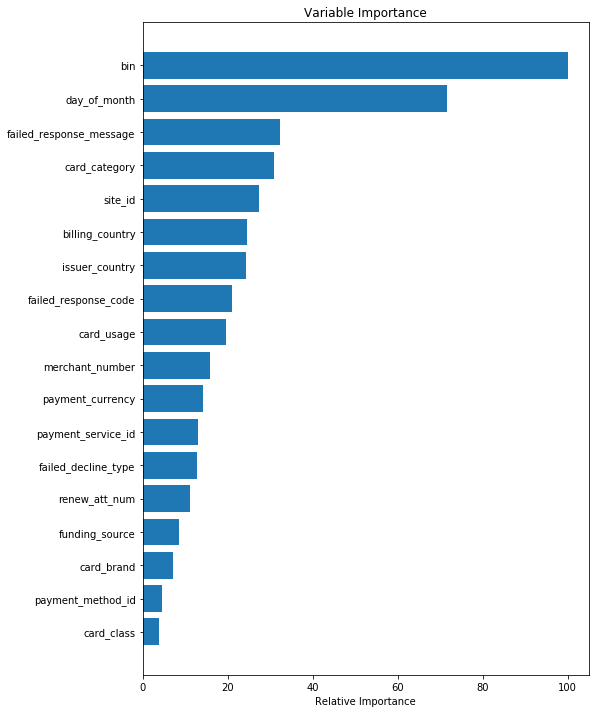

In [64]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
result_d

####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed']
# fit_time: 88.60165882110596
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed'],
              drop_invariant=False, handle_unknown='ignore',
              impute_missing=False, random_state=None, randomized=False,
              return_df=True, sigma=0.05, verbose=0)
In transform, self.bin_profile: (32272, 11) 


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 14615.566670179367
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country  day_of_month   site_id  billing_country  \
0        0.017554      0.018597  0.017928         0.017747   
1        0.018273      0.017741  0.018302         0.018235   
2        0.017679      0.018500  0.018225         0.017638   
3        0.017440      0.018183  0.018189         0.017483   
4        0.019526      0.018500  0.019147         0.019476   

   failed_decline_type  merchant_number  payment_service_id  \
0             0.017973         0.

[07:45:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[07:46:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[07:46:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[07:46:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[07:46:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[07:47:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[07:47:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[07:47:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[

[08:03:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[08:04:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[08:04:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[08:04:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[08:04:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[08:05:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[08:05:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[08:05:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[

[08:21:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[08:21:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[08:22:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[08:22:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[08:22:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[08:22:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[08:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[08:23:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10


[08:39:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[08:39:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[08:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[08:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[08:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[08:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[08:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[08:41:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10


[08:56:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[08:57:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[08:57:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[08:57:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[08:58:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[08:58:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[08:58:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[08:58:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10


[09:14:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[09:15:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[09:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[09:15:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[09:15:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[09:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[09:16:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[09:16:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10


[09:32:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[09:32:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[09:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[09:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[09:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[09:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[09:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[09:34:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10


[09:50:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[09:50:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[09:50:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[09:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[09:51:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[09:51:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[09:51:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[09:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10


[10:07:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[10:07:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[10:08:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[10:08:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[10:08:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[10:08:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[10:09:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[10:09:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[10:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[10:25:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[10:25:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[10:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[10:26:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:26:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[10:26:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[10:27:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10


[10:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[10:43:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[10:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[10:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[10:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[10:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[10:44:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[10:44:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[11:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[11:01:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[11:01:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[11:01:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[11:01:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[11:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[11:02:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[11:02:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


[11:18:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[11:18:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[11:19:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[11:19:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[11:19:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[11:20:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[11:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[11:20:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[

[11:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[11:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[11:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[11:37:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[11:37:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[11:38:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[11:38:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[11:38:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10


[11:53:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[11:54:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[11:54:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[11:54:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[11:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[11:55:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[11:55:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[11:55:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 21)
x_test (1683437, 21)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9882522039740539
training auc: 0.7219571610919168
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   4959668
          1       0.82      0.45      0.58     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 4229.577148199081
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country  day_of_month   site_id  billing_country  \
0        0.017679      0.018183  0.017917         0.017638   
1        0.017652      0.017499  0.017917         0.017696   
2        0.018019      0.017536  0.017928         0.017996   
3        0.018019      0.017451  0.017928         0.017996   
4        0.017679      0.018183  0.017917         0.017638   

   failed_decline_type  merchant_number  payment_service_id  \
0             0.017973          0.

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 36787.88076424599
feature_importance column  Index(['processor_mid_changed', 'expiration_date_changed', 'card_class',
       'payment_method_id', 'card_brand', 'funding_source', 'renew_att_num',
       'payment_currency', 'payment_service_id', 'merchant_number',
       'failed_decline_type', 'card_usage', 'issuer_country',
       'billing_country', 'site_id', 'card_category', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [7.1551226e-02 1.5684029e+00 4.1585574e+00 4.6765885e+00 7.6445332e+00
 8.5346308e+00 1.2097881e+01 1.4167144e+01 1.4421865e+01 1.8723526e+01
 2.0987406e+01 2.1410990e+01 2.5995995e+01 2.6614195e+01 3.0967369e+01
 3.2083572e+01 6.9882652e+01 1.0000000e+02]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9865453830467075
test auc: 0.6926845854027865
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1653296
          1       0.74      0.39      0.51     30141

avg / total       

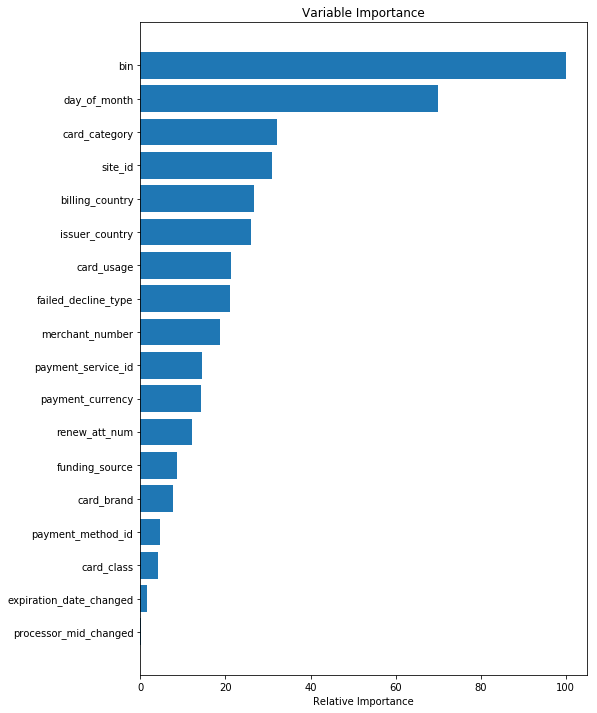

In [79]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
# fit_time: 226.36031794548035
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month'],
              drop_in

/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 16237.125749349594
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_service_id  payment_method

[12:16:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[12:17:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[12:17:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[12:17:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[12:18:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[12:18:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[12:18:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[12:19:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10


[12:39:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[12:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[12:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[12:40:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[12:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[12:41:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[12:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[12:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10


[13:01:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[13:02:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[13:02:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[13:02:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[13:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[13:03:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[13:03:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[13:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10


[13:24:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[13:24:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[13:25:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[13:25:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[13:25:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[13:26:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[13:26:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[13:26:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10


[13:47:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[13:47:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[13:47:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[13:48:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[13:48:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[13:48:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[13:49:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[13:49:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10


[14:09:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[14:09:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[14:10:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[14:10:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[14:10:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[14:11:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[14:11:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[14:11:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10


[14:32:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[14:32:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[14:32:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:33:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[14:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[14:33:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[14:34:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[14:34:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10


[14:54:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[14:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[14:55:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[14:55:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[14:56:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[14:56:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[14:56:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[14:57:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10


[15:17:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[15:17:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:18:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[15:18:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[15:18:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[15:19:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[15:19:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[15:19:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10


[15:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[15:40:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[15:40:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[15:41:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[15:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[15:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:42:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[15:42:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10


[16:02:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:02:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:03:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:03:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:03:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:04:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10


[16:25:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:25:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:25:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:26:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[16:26:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:26:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[16:27:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:27:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10


[16:48:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:48:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:48:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[16:49:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[16:49:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:49:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[16:50:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[16:50:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10


[17:11:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[17:11:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[17:12:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[17:12:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[17:12:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[17:13:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[17:13:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[17:13:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10


[17:34:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[17:34:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[17:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[17:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[17:35:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[17:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[17:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[17:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 27)
x_test (1683437, 22)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.990343561156357
training auc: 0.7796676018035248
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.85      0.56      0.68     90641

avg / total       0.99      0.99      0.99   5050309



/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 4281.005582332611
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_id  payment_method_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 46565.942445516586
feature_importance column  Index(['is_weekend', 'failed_cid', 'expiration_date_changed', 'card_class',
       'payment_method_id', 'is_expired', 'card_brand', 'funding_source',
       'failed_payment_service_id', 'renew_att_num', 'payment_currency',
       'payment_service_id', 'merchant_number', 'card_usage',
       'failed_merchant_number', 'failed_decline_type', 'issuer_country',
       'billing_country', 'week_of_month', 'site_id', 'card_category',
       'day_of_week', 'month', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  0.          1.4080669   1.4232073   3.4368944   4.530039    4.539123
   6.3650675   8.330306   10.731589   10.801235   12.175993   12.263808
  14.8921995  15.924782   17.132994   17.193556   23.043846   23.168
  23.428417   25.260418   30.217419   32.549057   38.193436   55.40213
 100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.987433447167907
test auc: 0.7300251222377638
           

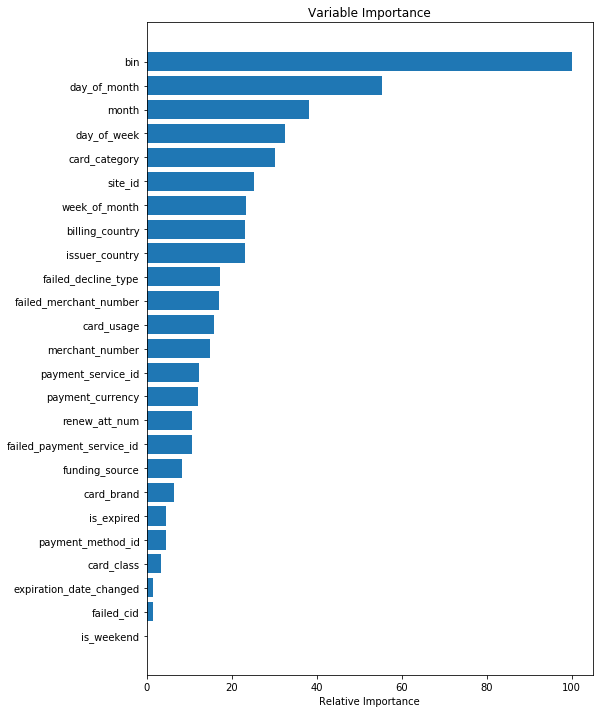

In [97]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_expired', 'month']


In [33]:
gp = retry_success.groupby(['failed_decline_type'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 1]

success          success_rate
                               sum    count             
failed_decline_type                                     
issuer unavailable            1255     1996    62.875752
no reply                      1525     2429    62.783038
unable to determine format     747     1283    58.222915
do_not_try_merchant_review    2632     4685    56.179296
server error                  3126     5659    55.239442
system error                  1039     2113    49.171794
litle http response code      1145     2933    39.038527
invalid merchant               110      293    37.542662
no charge model found         2493     6871    36.282928
international filtering        362     1124    32.206406
ioexception                    182      638    28.526646
acquirer error                1449     5219    27.763939
corrupt input data            1637     6375    25.678431
invalid_cc                    2803    40752     6.878190
expired_card                  7369   131063     5.622487
not_permitted                  162     6145     2.636290
do_not_honor                 25297  1061455     2.383238
txn_refused                  46511  2423006     1.919558
Base                          3993   252297     1.582659
declined                     16389  1038906     1.577525
attempt_lower_amount             1      137     0.729927
invalid_txn                     55    20163     0.272777
correct_cc_retry                88    86607     0.101608
not_allowed                     80   134882     0.059311
invalid_account                  2     3812     0.052466
Hard Fraud                     146   482290     0.030272
Insufficient Funds             183   992412     0.018440
blocked_first_used               1    18053     0.005539
Stop Recurring                   0      136     0.000000
restricted_card                  0       12     0.000000

In [40]:
gp = retry_success[retry_success['failed_decline_type'] == 'declined'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 50]

success          success_rate
                                               sum    count             
failed_response_message                                                 
Declined Non Generic: Declined Non Generic      97      808    12.004950
51: DECLINED                                 16270  1035192     1.571689
350: Generic Decline                            22     2714     0.810612
57: DECLINED                                     0      130     0.000000

In [ ]:
from IPython.display import display
pd.options.display.max_columns = None
retry_success.head()

In [ ]:
gp = retry_success.groupby(['bank_code'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp.columns = df_gp.columns.droplevel(0)
df_gp[df_gp['count'] > 500].rename(columns={'sum': 'success', 'count': 'overall', '':'success_rate'})

In [59]:
gp = retry_success[retry_success['failed_response_message'] == 'Invalid Card Type[] [] [] []'].groupby(['payment_service_id'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp.columns = df_gp.columns.droplevel(0)
df_gp[df_gp['count'] > 1].rename(columns={'sum': 'success', 'count': 'overall', '':'success_rate'})

,success,overall,success_rate
payment_service_id,,,
netgiro-seb,1310,3138,41.746335
netgiro-bnp,0,6,0.000000
netgiro-bms,0,2,0.000000


In [57]:
gp = retry_success.groupby(['expiration_date_changed'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp.columns = df_gp.columns.droplevel(0)
df_gp[df_gp['count'] > 1].rename(columns={'sum': 'success', 'count': 'overall', '':'success_rate'})

,success,overall,success_rate
expiration_date_changed,,,
True,5211,26878,19.387603
False,115571,6706868,1.723174


In [71]:
result = retry_success[retry_success['processor_mid_changed'] == 'processor_changed_mid_unchanged'].head(100)
# result.to_csv(WORK_DIR + 'processor_retry_processor_changed_mid_unchanged.csv')
result

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_attempt_date,failed_day_of_month,failed_response_code,failed_response_message,failed_decline_type,days_between,failed_event_uuid,failed_cc_expiration_date,expiration_date_changed,processor_mid_changed,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1,mean_diff,max_99_diff,std_diff
77296,77296,2018-05-06,avgstore,11372157101,6747308133,2018-05-06 01:59:41,NaN,NON3DS,ALIOR BANK SPOLKA AKCYJNA,PL,557506,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - No Pin Access,0821,RETRY_DECLINED.2,NaN,6,sunday,d4096683-bc8b-483c-a67f-3ea52951b3ad,NaN,Debit,PL,DRI*AVG Technologies,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,199.00,55.986437,PLN,MasterCard,netgiro-bms,1,199.00,55.986437,PLN,47631904600,27054.0,Attempt lower amount.[51] [] [111800] [111800],New,15603465300,2018-05-06 01:59:41,1,Authorize,0,2018-05-06 01:59:21,6,27054,Attempt lower amount.[51] [] [111800] [111800],Insufficient Funds,0,71f1f5af-2f37-415f-946a-afa216f42535,0821,False,processor_changed_mid_unchanged,32.607873,2.490000,162.112391,21.148875,71.757623,81.434008,4.157309,-23.378564,25.447571,-2.229689
77297,77297,2018-05-09,avgstore,11372157101,6758050813,2018-05-09 01:51:39,NaN,NON3DS,ALIOR BANK SPOLKA AKCYJNA,PL,557506,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - No Pin Access,0821,RETRY_DECLINED.2,NaN,9,wednesday,61cac6da-27ac-4d54-9edc-1795c7e351b9,NaN,Debit,PL,DRI*AVG Technologies,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,199.00,55.200271,PLN,MasterCard,netgiro-bms,2,199.00,55.200271,PLN,47735849500,27054.0,Attempt lower amount.[51] [] [111800] [111800],New,15603465300,2018-05-09 01:51:39,1,Authorize,0,2018-05-09 01:51:19,9,27054,Attempt lower amount.[51] [] [111800] [111800],Insufficient Funds,0,a68bde9d-dfb0-47b4-acc4-1004ad8422a7,0821,False,processor_changed_mid_unchanged,32.607873,2.490000,162.112391,21.148875,71.757623,81.434008,4.157309,-22.592398,26.233737,-1.443523
80719,80719,2018-06-08,avgstore,11693870401,6874329853,2018-06-08 06:51:38,NaN,NON3DS,MBANK S.A.,PL,557511,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - No Pin Access,1022,RETRY_DECLINED.2,NaN,8,friday,172c74a4-7da1-4d98-b632-57c49e697568,NaN,Debit,PL,DRI*AVG Technologies,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,139.00,38.617093,PLN,MasterCard,netgiro-bms,1,139.00,38.617093,PLN,48736934600,27001.0,Transaction refused[05] [] [111800] [111800],New,16189525800,2018-06-08 01:51:38,1,Authorize,0,2018-06-08 01:51:26,8,27001,Transaction refused[05] [] [111800] [111800],txn_refused,0,f75383ff-67b1-4807-8775-35e2239b64bc,1022,False,processor_changed_mid_unchanged,34.295354,2.253493,272.948385,22.938195,72.907720,90.431517,3.749263,-4.321739,51.814424,18.616455
80720,80720,2018-06-11,avgstore,11693870401,6889549233,2018-06-11 08:23:04,NaN,NON3DS,MBANK S.A.,PL,557511,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - No Pin Access,1022,RETRY_DECLINED.2,NaN,11,monday,0ef32cca-ad08-4c6c-a8ae-a58062f5c314,NaN,Debit,PL,DRI*AVG Technologies,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,139.00,38.179282,PLN,MasterCard,netgiro-bms,2,139.00,38.179282,PLN,48838170200,27001.0,Transaction refused[05] [] [111800] [111800],New,16189525800,2018-06-11 03:23:04,3,Authorize,0,2018-06-11 03:23:02,11,27001,Transaction ref

In [43]:
# FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
#                 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 
#                 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num',  
#                 'payment_currency',  'failed_response_message']

# FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
#                 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 
#                 'payment_service_id', 'payment_method_id',   'bin', 'renew_att_num',
#                 'payment_currency',  'failed_response_message']

# FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
#                   'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 
#                 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num',
#                 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 
#                 'failed_merchant_number', 'failed_response_code']

FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
                  'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 
                'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num',
                'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 
                'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'processor_att_num']


FEATURES_NUM = ['payment_amount_usd']
FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']
# FEATURES_NUM = []
FEATURES_NUM_CALCULATED = ['mean_diff', 'max_99_diff', 'std_diff', 'median_diff']
# FEATURES_NUM_CALCULATED = []
# FEATURES_ENCODED = [ 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_expired', 'month'] + FEATURES_NUM_CALCULATED
FEATURES_ENCODED = ['week_of_month', 'day_of_week', 'is_expired', 'month']
FEATURES_NUM_ENCODED = ['Mean', 'StdDev', 'Max_99', 'Median']
# FEATURES_NUM_ENCODED = []
FEATURES = FEATURES_CAT + FEATURES_ENCODED

# FEATURES_ALLOW_NA = ['failed_cid', '']

# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV

# from training import PreProcessing
# from sklearn.pipeline import make_pipeline
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'failed_response_message', 'failed_cc_expiration_date'] + FEATURES_NUM_ENCODED + FEATURES_NUM_CALCULATED
df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')
features_dict = {'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED, 'FEATURES_NUM_CALCULATED':FEATURES_NUM_CALCULATED, 'FEATURES_FLOAT': FEATURES_FLOAT}
features_dict_key = 'preprocessing__features_dict'
def display_feature_importance(pipe, model_name, df_features):
    classifier = pipe.named_steps[model_name]
    feature_importance = classifier.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    print("feature_importance column ",df_features.columns[sorted_idx])
    print("feature_importance val ",feature_importance[sorted_idx])
    pos = np.arange(sorted_idx.shape[0]) + .5
    pvals = feature_importance[sorted_idx]
    pcols = df_features.columns[sorted_idx]
    plt.figure(figsize=(8,12))
    plt.barh(pos, pvals, align='center')
    plt.yticks(pos, pcols)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

def build_and_train(df, clf, param_grid, model_name, model_file = '', best_param=None):
    model_prefix = model_name + '__'
    time_start = time.time()
    df_X = df[FIELDS]
    result_dict = {}
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(df_X, df[LABEL], \
                                                        test_size=0.25, random_state=42)
    y_pred_train = None
    print('####### bin_profile: {}'.format(bin_profile.shape))
    features_dict['df_bin_profile'] = bin_profile
    features_dict['df_decline_type'] = df_decline_type
    if best_param is None:
    
        pipe = make_pipeline(PreProcessing(bin_profile), Imputer(strategy="most_frequent", axis=0), clf())
#         pipe = make_pipeline(PreProcessing(bin_profile), clf())
        score = 'average_precision'#'f1' #'accuracy' #  ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
        print("# Tuning hyper-parameters for %s" % score)
        
        pipe_param_grid = {model_prefix + k: v for k, v in param_grid.items()}
        print("pipe_param_grid ", pipe_param_grid)
#         features_dict['df_bin_profile'] = bin_profile
        clf_gs = GridSearchCV(sc, pipe, pipe_param_grid, cv=3, scoring=score, n_jobs=-1, fit_params={features_dict_key: features_dict})
#         clf_gs = GridSearchCV(pipe, pipe_param_grid, cv=3, scoring=score, n_jobs=-1, fit_params={features_dict_key: features_dict})
        clf_gs = clf_gs.fit(x_train, y_train)

        print('clf_gs: {}'.format(clf_gs))

        best_model = clf_gs.best_estimator_  #clf_gs.estimator.named_steps[model_name]

        print("# Grid scores on development set:")
        means = clf_gs.cv_results_['mean_test_score']
        stds = clf_gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf_gs.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

        best_parameters = best_model.get_params(deep=True)
        print("# Best parameters set found on development set: {}".format(best_parameters))  

        best_parameters = {k.replace(model_prefix,''): v for k, v in best_parameters.items()}
        print('best params: {}'.format(best_parameters))
        pipe = best_model
        y_pred_train = pipe.predict(x_train).round()
    else:
        best_parameters= best_param
        pipe = make_pipeline(PreProcessing(bin_profile), Imputer(strategy="most_frequent", axis=0), clf(**best_parameters))
  

    if y_pred_train is None:
        if model_file != '':
            best_parameters['updater'] = 'refresh'
            best_parameters['refresh_leaf'] = True


        if model_name == 'xgbclassifier':
            print("training xgb ....... ")
            if model_file == '':
                y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__eval_metric='error').round()  
            else:
                print("Using model_file to train: ", model_file)
                y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__xgb_model=model_file, xgbclassifier__eval_metric='error').round()  
        else:        
            y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict).round()  
        
    
    print("best_parameters ", best_parameters)        
    print("x_train", x_train.shape)
    print("x_test", x_test.shape)
    
        
    print("pipe:", pipe)
    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
    print("training accuracy:", train_accuracy)
    
    train_auc = metrics.roc_auc_score(y_train, y_pred_train)
    print("training auc:", train_auc)
    
    train_class_report = metrics.classification_report(y_train, y_pred_train)
    print(train_class_report)

    
    y_pred_test = pipe.predict(x_test).round()

    training_time = time.time() - time_start
    print("# training time:", training_time)
    result_dict['training_time'] = training_time
    
    '''Dummy classifier for comparison'''
    clf_d = DummyClassifier(strategy='most_frequent')
    clf_d.fit(np.zeros_like(x_train), y_train.astype(np.float))
    y_pred_test_dummy = clf_d.predict(np.zeros_like(x_test)).round()
    accuracy_dummy = metrics.accuracy_score(y_test, y_pred_test_dummy)
    '''End of Dummy Classifier'''
    
    test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
    
    result_dict['accuracy_dummy'] = accuracy_dummy
    result_dict['train_accuracy'] = train_accuracy
    result_dict['test_accuracy'] = test_accuracy
#     print_accuracy_report(pipe, x_train, y_train, num_validations=3)
#     print(metrics.classification_report(y_test, y_pred_test))
    test_class_report = metrics.classification_report(y_test, y_pred_test)
    result_dict['train_class_report'] = train_class_report
    result_dict['test_class_report'] = test_class_report
    conf_mx = metrics.confusion_matrix(y_test, y_pred_test)
    
    preprocess = pipe.named_steps['preprocessing']
    df_features = x_train[preprocess.features_all]
    display_feature_importance(pipe, model_name, df_features)
    
    test_auc = metrics.roc_auc_score(y_test, y_pred_test)
    result_dict['train_auc'] = train_auc
    result_dict['test_auc'] = test_auc
    
    print("accuracy_dummy:", accuracy_dummy)
    
    
    print("test accuracy:", test_accuracy)
    print("test auc:", test_auc)
    print(test_class_report)
    
    print("# confusion_matrix -  test:\n", conf_mx)
    result_dict['conf_mx'] = conf_mx.tolist()

    return pipe, result_dict


In [21]:
retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_response_code,failed_response_message,failed_decline_type,failed_event_uuid,failed_cc_expiration_date,expiration_date_changed,processor_mid_changed,failed_cid,failed_payment_service_id,failed_merchant_number,processor_att_num
0,0,2019-02-03,avast,10007475401,8230718493,2019-02-03 14:38:20,2.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0420,RETRY_DECLINED.2,2.0,3,sunday,af5fedf6-62f6-489c-8fea-4a72b5c2e97b,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,114.700000,EUR,MasterCard,netgiro-bms,1,99.99,114.700000,EUR,57531456100,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-03 08:38:20,8,Authorize,0,530.0,Refused: Refused,txn_refused,d9683bf6-9d95-416e-9e46-a02a7b237bb0,0420,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2
1,1,2019-02-08,avast,10007475401,8258737853,2019-02-08 12:15:40,0.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0418,RETRY_DECLINED.2,0.0,8,friday,840199bd-00a6-426d-aa44-e4a155f48067,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,113.440000,EUR,MasterCard,netgiro-bms,2,99.99,113.440000,EUR,57730537600,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-08 06:15:40,6,Authorize,0,522.0,05: Do not honor,do_not_honor,efae77a9-9eba-47eb-8200-d3d235f2424a,0418,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2
2,2,2019-03-07,adbehkr,10059085901,8421456683,2019-03-07 06:41:52,NaN,NON3DS,"HYUNDAICARD CO., LTD.",KR,552290,MasterCard,World MasterCard Card,Consumer,Credit - True credit (No PIN/Signature capability),0922,RETRY_DECLINED.2,NaN,7,thursday,ade6ea11-11c1-4d9a-9e52-60bc4ed4c6fd,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.800000,KRW,MasterCard,netgiro-bms,1,11000.00,9.800000,KRW,58876377200,27050.0,Do not try again/use alternate payment card.[62] [] [144800] [144800],New,18805274000,2019-03-07 00:41:52,0,Authorize,0,27001.0,Transaction refused[62] [000000] [] [],Hard Fraud,27c2e03c-15c5-4b43-a222-c40f65023c1f,0922,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2
3,3,2019-01-11,adbehkr,10076134701,8095353453,2019-01-11 06:40:54,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221,RETRY_DECLINED.2,NaN,11,friday,ce3cb7bb-0bdc-4552-9485-fb2f978cd68b,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.843372,KRW,Visa,netgiro-bms,1,11000.00,9.843372,KRW,56551670600,27001.0,Transaction refused[05] [] [111800] [111800],New,18181256200,2019-01-11 00:40:54,0,Authorize,0,27001.0,Transaction refused[05] [000000] [] [],txn_refused,2faa2dd5-13e0-4f30-9daa-ae74bafb81f2,0221,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2
4,4,2019-01-18,adbehkr,10076134701,8137731603,2019-01-18 06:52:14,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221,RETRY_DEC

####### bin_profile: (45130, 11)
# df_bin_profile: (45130, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'processor_att_num', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd']
# fit_time: 30.175560474395752
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_pa...xpiration_date_changed', 'processor_att_num', 'week_of_month', 'day_o

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

# transform_time: 4483.0318722724915
[15:01:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[15:01:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[15:01:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[15:01:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[15:01:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[15:01:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[15:01:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[15:01:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra

[15:06:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[15:06:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[15:06:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[15:06:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[15:06:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[15:06:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[15:06:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[15:07:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10


[15:11:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[15:11:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[15:11:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[15:12:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[15:12:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[15:12:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[15:12:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[15:12:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10


[15:17:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[15:17:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[15:17:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[15:17:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[15:17:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[15:17:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[15:17:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[15:17:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10


[15:22:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[15:22:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[15:22:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[15:22:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[15:22:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:22:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[15:22:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[15:23:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10


[15:27:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:27:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[15:27:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[15:28:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[15:28:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[15:28:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:28:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[15:28:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[15:33:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[15:33:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[15:33:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[15:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[15:33:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[15:33:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[15:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[15:33:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10


[15:38:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[15:38:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[15:38:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[15:38:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[15:38:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[15:38:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[15:38:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[15:39:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[

[15:43:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[15:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[15:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[15:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[15:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[15:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[15:44:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[15:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10


[15:49:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[15:49:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[15:49:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[15:49:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[15:49:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[15:49:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[15:49:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[15:49:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10


[15:54:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[15:54:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[15:54:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[15:54:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[15:54:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[15:54:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[15:54:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[15:55:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10


[15:59:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[15:59:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[15:59:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:59:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:00:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[16:00:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:00:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:00:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10


[16:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:05:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[

[16:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:10:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:10:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:10:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:10:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:10:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[16:10:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10


[16:15:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:15:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:15:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:15:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:16:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:16:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[16:16:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:16:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10


[16:21:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:21:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:21:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:21:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[16:21:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:21:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:21:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[16:21:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1448037, 33)
x_test (482680, 29)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9936334499739993
training auc: 0.8523285756947212
             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1423765
          1       0.89      0.71      0.79     24272

avg / total       0.99      0.99      0.99   1448037



/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

# transform_time: 1305.0702805519104


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 11571.040986776352
feature_importance column  Index(['processor_mid_changed', 'expiration_date_changed', 'processor_att_num',
       'failed_cid', 'card_class', 'is_expired', 'payment_method_id',
       'card_brand', 'funding_source', 'failed_payment_service_id',
       'payment_service_id', 'renew_att_num', 'failed_response_code', 'month',
       'payment_currency', 'failed_decline_type', 'card_usage',
       'billing_country', 'merchant_number', 'failed_merchant_number',
       'site_id', 'issuer_country', 'week_of_month', 'day_of_week',
       'bank_code', 'card_category', 'day_of_month', 'bin',
       'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.           0.185109     0.33936653   0.5450432    2.84348
   3.7793088    4.308926     5.7178116    8.309338     9.214315
   9.687371    10.155285    10.561498    10.792884    11.631016
  12.808514    16.479843    17.040312    17.796173    18.418344
  19.93007     20.223158    21.256681    26.61

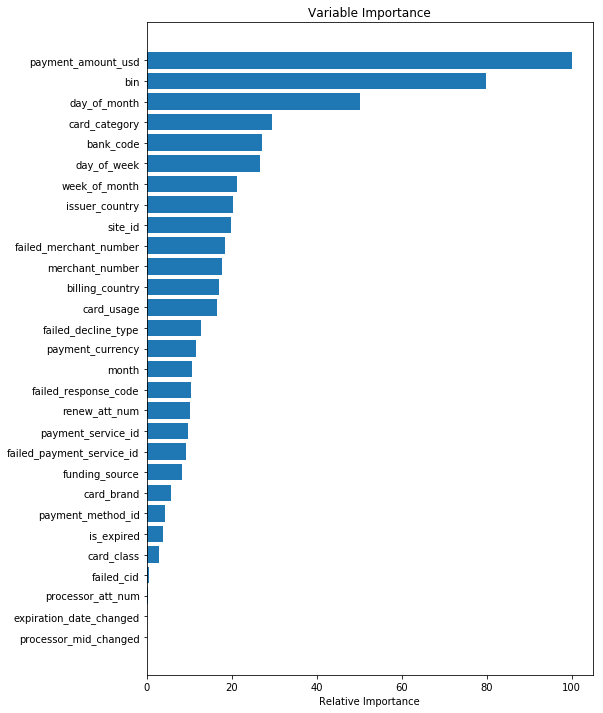

In [20]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 113.39248371124268
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merch

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 16
# transform_time: 23836.39086484909
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_service

[10:06:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[10:07:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[10:07:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[10:08:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[10:09:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[10:09:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[10:10:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[10:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10


[10:45:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[10:46:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[10:47:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[10:48:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[10:49:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[10:49:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[10:50:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10


[11:25:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[11:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[11:26:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[11:27:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[11:27:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[11:28:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[11:29:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[11:29:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[12:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[12:05:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[12:06:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[12:06:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[12:07:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[12:07:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[12:08:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[12:08:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[12:44:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[12:44:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[12:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[12:45:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[12:46:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[12:46:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[12:47:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[12:48:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10


[13:23:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[13:23:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[13:24:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=10
[13:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[13:25:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[13:26:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[13:26:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[13:27:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[14:02:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[14:02:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[14:03:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[14:04:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[14:04:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[14:05:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[14:05:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[14:06:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10


[14:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[14:42:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[14:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[14:43:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[14:44:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[14:45:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:45:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[15:20:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[15:21:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[15:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[15:22:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[15:22:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[15:23:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[15:23:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[15:24:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[15:59:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[15:59:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[16:00:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[16:00:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:01:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:02:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[16:02:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[16:03:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10


[16:38:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[16:39:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[16:40:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:41:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[16:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10


[17:18:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[17:19:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[17:19:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[17:20:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[17:21:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[17:21:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[17:22:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[17:22:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[17:57:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[17:58:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[17:59:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[17:59:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[18:00:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:00:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[18:01:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[18:01:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10


[18:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[18:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[18:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[18:37:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[18:38:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[18:38:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[18:39:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[18:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10


[19:13:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[19:14:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[19:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[19:15:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[19:15:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[19:16:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[19:17:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[19:17:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 39)
x_test (1683437, 35)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.992802420604363
training auc: 0.8382150063263601
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.90      0.68      0.77     90641

avg / total       0.99      0.99      0.99   5050309



/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 5
# transform_time: 6483.835409402847
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 69301.52389574051
feature_importance column  Index(['processor_mid_changed', 'failed_cid', 'expiration_date_changed',
       'card_class', 'payment_method_id', 'is_expired', 'card_brand',
       'funding_source', 'payment_currency', 'failed_payment_service_id',
       'failed_response_code', 'renew_att_num', 'payment_service_id',
       'billing_country', 'issuer_country', 'failed_decline_type',
       'merchant_number', 'card_usage', 'failed_merchant_number', 'site_id',
       'card_category', 'week_of_month', 'Min', 'day_of_week', 'month',
       'Min_1', 'Max_95', 'Max_99', 'Max', 'StdDev', 'bin', 'bank_code',
       'Mean', 'day_of_month', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [9.0095162e-02 1.1712371e+00 1.6329749e+00 2.7141166e+00 3.9360325e+00
 4.5498056e+00 5.2930908e+00 6.1602569e+00 8.0241003e+00 9.3867893e+00
 1.0428515e+01 1.1408300e+01 1.2055859e+01 1.3581845e+01 1.3587477e+01
 1.4280083e+01 1.4696774e+01 1.4696774e+01 1.5676

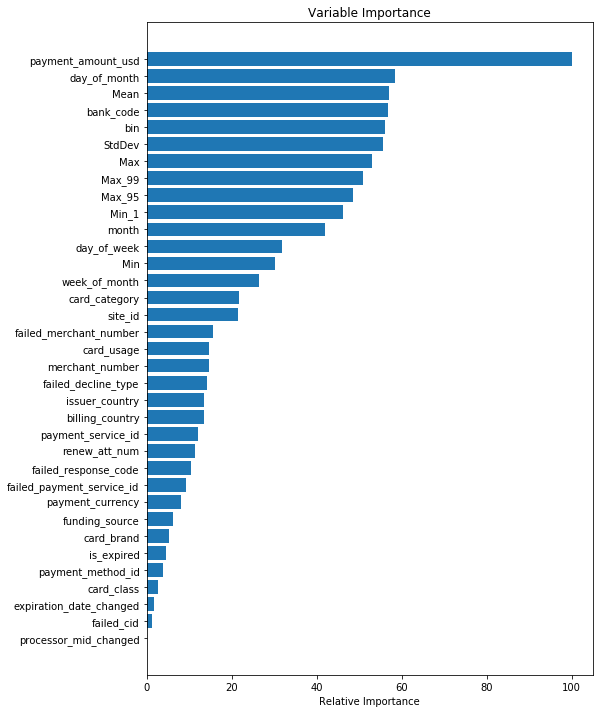

In [70]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ti

Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd']
# fit_time: 115.04055690765381
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/

Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 16
# transform_time: 24278.555544137955
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_servic

[10:24:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[10:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[10:25:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[10:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[10:26:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[10:26:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[10:27:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[10:27:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10


[10:51:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[10:51:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[10:51:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[10:52:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[10:52:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[10:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[10:53:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[10:53:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10


[11:17:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[11:17:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[11:17:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[11:18:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[11:18:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[11:19:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[11:19:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[11:19:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10


[11:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[11:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[11:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[11:44:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[11:45:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[11:45:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[11:45:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[11:46:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10


[12:10:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[12:11:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[12:11:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[12:12:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[12:12:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[12:12:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[12:13:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[12:13:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10


[12:38:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[12:38:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[12:39:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[12:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[12:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[12:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[12:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[12:41:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10


[13:06:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[13:06:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[13:07:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[13:07:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[13:07:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[13:08:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[13:08:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[13:09:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10


[13:33:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[13:34:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[13:34:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[13:35:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[13:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[13:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[13:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[13:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10


[14:01:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[14:01:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[14:02:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[14:02:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[14:02:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[14:03:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[14:03:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[14:04:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10


[14:28:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[14:29:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[14:29:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[14:29:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[14:30:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[14:30:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[14:31:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[14:31:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10


[14:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[14:55:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[14:56:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[14:56:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[14:56:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[14:57:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[14:57:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[14:58:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10


[15:22:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[15:23:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:23:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[15:24:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[15:24:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[15:25:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[15:25:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10


[15:50:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[15:51:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[15:51:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[15:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[15:52:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[15:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[15:53:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[15:53:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10


[16:18:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[16:19:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[16:19:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:19:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[16:20:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:20:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[16:21:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[16:21:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10


[16:45:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[16:46:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:46:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[16:47:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[16:47:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:47:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[16:48:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:48:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 32)
x_test (1683437, 28)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9913836955322932
training auc: 0.8026388160490624
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.87      0.61      0.72     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/

Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 5
# transform_time: 6508.339615821838
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 58940.00705909729
feature_importance column  Index(['processor_mid_changed', 'failed_cid', 'expiration_date_changed',
       'card_class', 'payment_method_id', 'is_expired', 'card_brand',
       'funding_source', 'failed_payment_service_id', 'renew_att_num',
       'payment_currency', 'payment_service_id', 'failed_response_code',
       'failed_decline_type', 'merchant_number', 'failed_merchant_number',
       'card_usage', 'billing_country', 'issuer_country', 'site_id',
       'week_of_month', 'day_of_week', 'card_category', 'month', 'bank_code',
       'day_of_month', 'payment_amount_usd', 'bin'],
      dtype='object')
feature_importance val  [8.7507293e-02 1.3542795e+00 1.4376199e+00 3.6669724e+00 4.5878825e+00
 4.6920576e+00 6.6547213e+00 8.7965670e+00 9.9258270e+00 1.0192515e+01
 1.0850904e+01 1.1184265e+01 1.1271772e+01 1.5151262e+01 1.5151262e+01
 1.6359695e+01 1.6459705e+01 2.0210016e+01 2.1430952e+01 2.2856070e+01
 2.3351946e+01 2.8894075e+01 3.0623384e+01 3.8

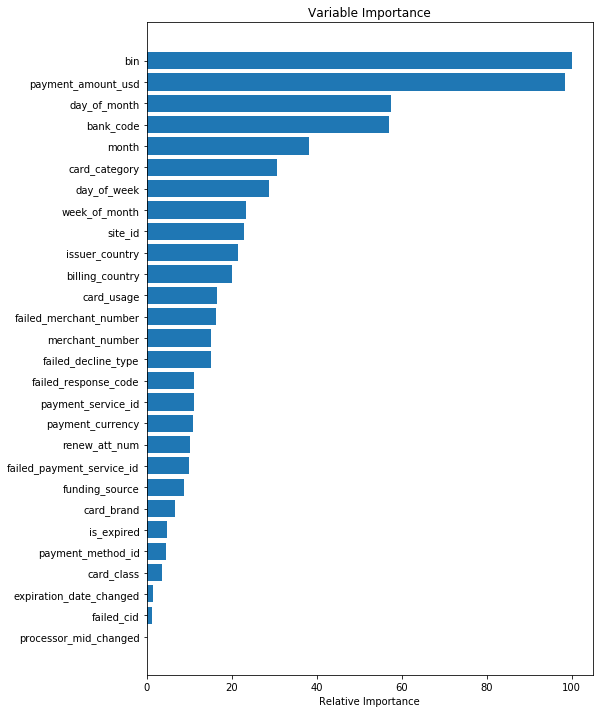

In [38]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'expiration_date_changed', 'payment_amount_usd']
# fit_time: 164.84890985488892
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'week_of_month', 'day_of_week', 'is_

/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 22
# transform_time: 25730.924157857895
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_servic

[16:19:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[16:20:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[16:20:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:21:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[16:21:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[16:21:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:22:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:22:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10


[16:49:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:49:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:50:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[16:50:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[16:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:51:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[16:51:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[16:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


[17:16:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[17:17:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[17:17:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[17:18:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[17:18:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[17:19:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[17:19:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[17:19:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10


[17:45:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[17:45:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[17:45:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[17:46:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[17:46:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[17:47:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[17:47:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[17:47:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10


[18:12:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[18:12:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[18:13:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[18:13:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[18:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[18:14:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[18:15:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[18:15:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10


[18:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[18:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[18:42:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[18:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[18:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[18:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[18:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[18:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10


[19:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[19:08:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[19:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[19:08:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[19:09:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[19:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[19:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[19:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10


[19:34:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[19:34:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[19:34:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[19:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[19:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[19:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[19:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[19:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10


[20:00:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[20:01:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[20:01:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[20:02:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[20:02:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[20:03:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[20:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10


[20:27:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:27:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[20:28:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[20:28:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[20:29:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[20:29:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[20:29:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[20:30:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10


[20:54:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[20:54:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[20:55:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[20:55:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[20:56:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[20:56:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:56:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[20:57:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10


[21:21:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[21:21:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[21:22:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[21:22:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[21:22:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[21:23:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[21:23:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[21:23:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10


[21:47:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[21:48:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[21:48:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[21:49:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[21:49:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[21:49:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[21:50:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[21:50:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10


[22:14:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[22:15:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[22:15:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[22:16:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[22:16:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[22:17:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[22:17:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[22:17:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10


[22:42:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[22:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[22:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[22:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[22:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[22:44:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[22:45:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[22:45:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 31)
x_test (1683437, 26)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9913205310803754
training auc: 0.8011228221675398
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.87      0.60      0.71     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 7
# transform_time: 6842.514727830887
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 62427.48817110062
feature_importance column  Index(['failed_cid', 'expiration_date_changed', 'card_class', 'is_expired',
       'payment_method_id', 'card_brand', 'funding_source',
       'failed_payment_service_id', 'renew_att_num', 'payment_currency',
       'failed_response_code', 'payment_service_id', 'failed_decline_type',
       'merchant_number', 'failed_merchant_number', 'card_usage',
       'billing_country', 'issuer_country', 'site_id', 'week_of_month',
       'day_of_week', 'card_category', 'month', 'day_of_month', 'bank_code',
       'bin', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  1.3921988   1.9273381   3.8170495   4.406539    4.6657467   6.6265316
   8.1985035   9.912622   10.100758   10.539738   11.601655   11.84414
  13.9261675  14.933735   15.811698   16.886158   20.197334   21.731678
  22.910658   23.362183   30.28973    32.472095   38.80179    54.655296
  59.174717   98.967354  100.       ]
accuracy_dummy: 0.98209555807

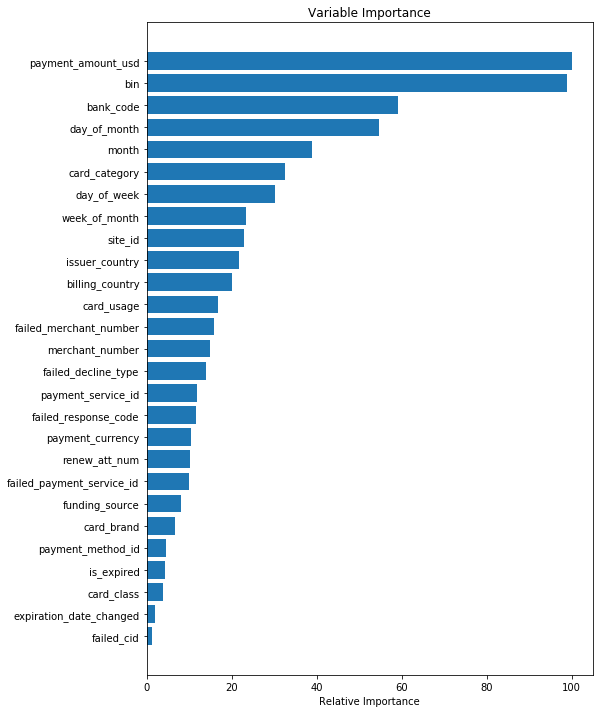

In [30]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [24]:
retry_success['success'].value_counts(normalize=True)

0    0.982063
1    0.017937
Name: success, dtype: float64

In [76]:
gp = retry_success.groupby(['failed_decline_type'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp


success          success_rate
                               sum    count             
failed_decline_type                                     
unable to determine format     747     1283    58.222915
system error                  6491    15858    40.932022
do_not_try                    2838    33623     8.440651
expired_card                  7367   131055     5.621304
Base                         11593   243081     4.769192
invalid_cc                    1473    37547     3.923083
not_permitted                  162     6138     2.639296
do_not_honor                 25280  1061354     2.381863
txn_refused                  46487  2422853     1.918688
declined                     16376  1038845     1.576366
attempt_lower_amount             1      137     0.729927
Hard Fraud                    1468   485393     0.302435
invalid_txn                     54    20159     0.267870
correct_cc_retry                87    86594     0.100469
not_allowed                     80   134881     0.059312
invalid_account                  2     3810     0.052493
Insufficient Funds             177   992370     0.017836
blocked_first_used               1    18052     0.005540
Stop Recurring                   0      136     0.000000
restricted_card                  0       12     0.000000

In [272]:
gp = retry_success[retry_success['failed_decline_type'] == 'txn_refused'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success          \
                                                        sum   count   
failed_response_message                                               
Transaction refused[30] [] [] []                       1488    4146   
Transaction refused[002] [null] [] []                   208     801   
Transaction refused[N0] [000000] [] []                  472    3238   
Transaction refused[05] [] [111880] [111880]            164    1185   
Transaction refused[100] [] [] []                       831    9629   
Transaction refused[12] [000000] [] []                 1674   19416   
Transaction refused[05] [] [111200] [111200]            784   11670   
Transaction refused[null] [null] [null] [null]         7159  139438   
Refused: Refused                                       1080   23702   
Transaction refused[05] [] [000800] [000800]            212    8501   
Transaction refused[05] [] [124840] [124840]            197    8250   
Transaction refused[05] [] [111820] [111820]            110    4615   
Transaction refused[05] [] [144800] [144800]            534   23351   
Transaction refused[05] [000000] [] []                10846  486388   
27001: Transaction refused[57] [000000] [] []            14     628   
Transaction refused[54] [000000] [] []                 1763   85901   
Transaction refused[05] [] [111800] [111800]          11414  585963   
Transaction refused[05] [] [142820] [142820]             14     725   
27001: Transaction refused[05] [000000] [] []            45    2380   
Transaction refused[05] [] [122800] [122800]            956   52263   
Transaction refused[05] [null] [] []                   1211   68584   
27001: Transaction refused[05] [] [] []                  12     710   
Transaction refused[05] [] [144820] [144820]             49    2920   
27001: Transaction refused[05] [] [111800] [111800]      45    2957   
Transaction refused[05] [] [142800] [142800]             54    3564   
Transaction refused[57] [000000] [] []                 1900  138929   
Transaction refused[57] [] [] []                        144   10772   
Transaction refused[05] [] [144840] [144840]            106    8538   
Transaction refused[05] [] [122840] [122840]            219   19199   
Transaction refused[02] [] [111800] [111800]             18    1618   
...                                                     ...     ...   
Transaction refused[05] [] [] []                       1458  139192   
Transaction refused[05] [000000] [] [N]                  52    5585   
Transaction refused[05] [] [111840] [111840]            210   25552   
Transaction refused[05] [] [124800] [124800]            230   28387   
Transaction refused[05] [] [142840] [142840]              9    1217   
Transaction refused[65] [000000] [] []                    6     951   
Transaction refused[54] [null] [] []                     50   12833   
Transaction refused[61] [000000] [] []                  109   38616   
Transaction refused[54] [000000] [] [N]                  22   13207   
Transaction refused[T8] [000000] [] []                  259  158407   
Transaction refused[56] [000000] [] []                   18   19478   
Transaction refused[03] [000000] [] []                    1    1244   
Transaction refused[56] [] [] []                         53   76028   
Transaction refused[57] [null] [] []                     39   66931   
Transaction refused[05] [] [122820] [122820]              2    3917   
Transaction refused[05] [] [124820] [124820]              2    4576   
Transaction refused[54] [] [] []                         21   51625   
Transaction refused[06] [null] [] []                      0   17405   
Transaction refused[05] [] [111810] [111810]              0    4007   
Transaction refused[14] [000000] [] []                    0    2371   
Transaction refused[111] [] [] []                         0    2061   
Transaction refused[78] [null] [] []                      0    1477   
Transaction refused[15] [null] [] []                      0    1040   
Trans

In [267]:
gp = retry_success[retry_success['failed_decline_type'] == 'do_not_try'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success         \
                                                               sum  count   
failed_response_message                                                     
Do not try again/merchant review.[30] [] [111800] [111800]    2097   3649   
27053: Do not try again/merchant review                        508    908   
51: DO NOT TRY AGAIN                                           193   9497   
63: DO NOT TRY AGAIN                                            11  16035   
57: DO NOT TRY AGAIN                                             2   3244   

                                                           success_rate  
                                                                         
failed_response_message                                                  
Do not try again/merchant review.[30] [] [111800] [111800]    57.467799  
27053: Do not try again/merchant review                       55.947137  
51: DO NOT TRY AGAIN                                           2.032221  
63: DO NOT TRY AGAIN                                           0.068600  
57: DO NOT TRY AGAIN                                           0.061652

In [257]:
gp = retry_success[retry_success['failed_decline_type'] == 'Hard Fraud'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success          \
                                                        sum   count   
failed_response_message                                               
Invalid Card Type[] [] [] []                           1310    3146   
Transaction refused[01] [000000] [] []                   63     995   
Card type is not allowed[null] [null] [null] [null]       1     563   
Transaction refused[62] [000000] [] []                   31   48693   
Transaction refused[62] [null] [] []                     12   29957   
303: Pick Up Card                                         1    2632   
Transaction refused[59] [] [] []                         16   88209   
Transaction refused[04] [000000] [] []                   15  258339   
Transaction refused[41] [] [] []                          0   15810   
Transaction refused[43] [] [] []                          0    7071   
Transaction refused[34] [] [] []                          0    6255   
004: Pickup card                                          0    3256   
Transaction refused[07] [null] [] []                      0    3147   
043: Pickup card                                          0    2100   
Transaction refused[04] [null] [] []                      0    1973   
304: Lost/Stolen Card                                     0    1956   
062: Restricted card                                      0    1925   
041: Pickup card                                          0    1732   
Transaction refused[41] [null] [] []                      0    1697   
27001: Transaction refused[04] [000000] [] []             0    1293   
Transaction refused[04] [] [] []                          0    1233   
Transaction refused[04] [000000] [] [N]                   0     632   
307: Restricted Card                                      0     613   

                                                    success_rate  
                                                                  
failed_response_message                                           
Invalid Card Type[] [] [] []                           41.640178  
Transaction refused[01] [000000] [] []                  6.331658  
Card type is not allowed[null] [null] [null] [null]     0.177620  
Transaction refused[62] [000000] [] []                  0.063664  
Transaction refused[62] [null] [] []                    0.040057  
303: Pick Up Card                                       0.037994  
Transaction refused[59] [] [] []                        0.018139  
Transaction refused[04] [000000] [] []                  0.005806  
Transaction refused[41] [] [] []                        0.000000  
Transaction refused[43] [] [] []                        0.000000  
Transaction refused[34] [] [] []                        0.000000  
004: Pickup card                                        0.000000  
Transaction refused[07] [null] [] []                    0.000000  
043: Pickup card                                        0.000000  
Transaction refused[04] [null] [] []                    0.000000  
304: Lost/Stolen Card                                   0.000000  
062: Restricted card                                    0.000000  
041: Pickup card                                        0.000000  
Transaction refused[41] [null] [] []                    0.000000  
27001: Transaction refused[04] [000000] [] []           0.000000  
Transaction refused[04] [] [] []                        0.000000  
Transaction refused[04] [000000] [] [N]                 0.000000  
307: Restricted Card                                    0.000000

In [265]:
gp = retry_success[retry_success['failed_decline_type'] == 'system error'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success        \
                                                                  sum count   
failed_response_message                                                       
System error[] [] [] []                                           702   989   
27002: NetGiro server error                                      2169  3447   
Server error, no transaction sent to acquirer[] [] [] []          641  1355   
27034: System error                                               297   632   
Acquirer error. Transaction not processed.[02] [000000] [] []     965  3166   
27033: Acquirer error.  Transaction not processed                 406  1747   
006: Error                                                          3   615   

                                                              success_rate  
                                                                            
failed_response_message                                                     
System error[] [] [] []                                          70.980789  
27002: NetGiro server error                                      62.924282  
Server error, no transaction sent to acquirer[] [] [] []         47.306273  
27034: System error                                              46.993671  
Acquirer error. Transaction not processed.[02] [000000] [] []    30.480101  
27033: Acquirer error.  Transaction not processed                23.239840  
006: Error                                                        0.487805

In [258]:
gp = retry_success[retry_success['failed_decline_type'] == 'Base'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success  \
                                                                               sum   
failed_response_message                                                              
313: International filtering for issuing card country                          361   
328: Cardholder requested that recurring or installment payment be stopped      21   
01: Refer to card issuer                                                       296   
530                                                                              8   
14: INV ACCT NUM                                                               254   
Not enough balance: Not enough balance                                           9   
51: NEW ACCOUNT INFO                                                             1   
12: INV TRAN                                                                     2   
25: Unable to locate record on file                                              0   
015: No such issuer                                                              0   
57: TRY AGAIN LATER                                                              0   
323: No such issuer                                                              0   

                                                                                   \
                                                                            count   
failed_response_message                                                             
313: International filtering for issuing card country                        1116   
328: Cardholder requested that recurring or installment payment be stopped    631   
01: Refer to card issuer                                                    22293   
530                                                                          2079   
14: INV ACCT NUM                                                            97333   
Not enough balance: Not enough balance                                       4257   
51: NEW ACCOUNT INFO                                                          690   
12: INV TRAN                                                                 2643   
25: Unable to locate record on file                                          2455   
015: No such issuer                                                          1886   
57: TRY AGAIN LATER                                                           586   
323: No such issuer                                                           506   

                                                                           success_rate  
                                                                                         
failed_response_message                                                                  
313: International filtering for issuing card country                         32.347670  
328: Cardholder requested that recurring or installment payment be stopped     3.328051  
01: Refer to card issuer                                                       1.327771  
530                                                                            0.384800  
14: INV ACCT NUM                                                               0.260960  
Not enough balance: Not enough balance                                         0.211416  
51: NEW ACCOUNT INFO                                                           0.144928  
12: INV TRAN                                                                   0.075672  
25: Unable to locate record on file                                            0.000000  
015: No such issuer                                                            0.000000  
57: TRY AGAIN LATER                                                            0.000000  
323: No such issuer                                                            0.000000

In [259]:
gp = retry_success[retry_success['failed_decline_type'] == 'expired_card'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success        success_rate
                                           sum  count             
failed_response_message                                           
54: EXPIRED CARD                          4446  45307     9.813053
054: Expired card                          742  15817     4.691155
Expired card.[54] [] [111800] [111800]    2074  54631     3.796379
305: Expired Card                           42   6012     0.698603
Expired Card: Expired Card                  16   2915     0.548885
54: Expired Card                             1   3953     0.025297
Expired card.[54] [] [111810] [111810]       0   1105     0.000000

In [261]:
gp = retry_success[retry_success['failed_decline_type'] == 'invalid_cc'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success        success_rate
                             sum  count             
failed_response_message                             
27019: Invalid card type     958   2194    43.664540
014: Invalid Card Number      17  33128     0.051316
14: Invalid card number        0   1251     0.000000

In [250]:
gp = retry_success.groupby(['failed_decline_type'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp


success          success_rate
                                 sum    count             
failed_decline_type                                       
issuer unavailable              1255     1996    62.875752
no reply                        1525     2428    62.808896
unable to determine format       747     1283    58.222915
system error                    6491    15858    40.932022
litle http response code        1145     2933    39.038527
invalid merchant                 110      293    37.542662
no charge model found           2493     6871    36.282928
ioexception                      182      638    28.526646
corrupt input data to server    1637     6375    25.678431
do_not_try                      2838    33623     8.440651
expired_card                    7367   131055     5.621304
invalid_cc                      1473    37547     3.923083
not_permitted                    162     6138     2.639296
do_not_honor                   25280  1061354     2.381863
txn_refused                    46487  2422853     1.918688
declined                       16376  1038845     1.576366
Base                            3246   221547     1.465152
attempt_lower_amount               1      137     0.729927
Hard Fraud                      1468   485393     0.302435
invalid_txn                       54    20159     0.267870
correct_cc_retry                  87    86594     0.100469
not_allowed                       80   134881     0.059312
invalid_account                    2     3810     0.052493
Insufficient Funds               177   992370     0.017836
blocked_first_used                 1    18052     0.005540
Stop Recurring                     0      136     0.000000
restricted_card                    0       12     0.000000

In [203]:
retry_success[retry_success['failed_response_message'] == 'Litle HTTP response code: 503']['failed_response_code'].value_counts()
# retry_success['failed_response_code'].value_counts()

0.0    316
000     14
Name: failed_response_code, dtype: int64

In [19]:
df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

# msg_group = { 'declined' : 'decline', 
#              'do_not_honor' : 'do not honor', 
#              'txn_refused' : 'refuse', 
#              'attempt_lower_amount' : 'lower amount',
#             'Insufficient Funds' : 'insufficient',
#             'not_allowed' : 'not allowed',
#             'correct_cc_retry' : 'correct card',
#             'invalid_cc' : 'invalid card',
#             'lost_stolen' : 'lost or stolen',
#             'invalid_account' : 'invalid account',
#             'do_not_try' : 'do not try',
#             'expired_card' : 'expired',
#             'pickup_card' : 'pick',
#             'blocked_first_used' : 'blocked',
#             'invalid_txn' : 'invalid trans',
#             'restricted_card' : 'restricted',
#             'not_permitted' : 'not permitted',
#             'expired card' : 'expired card',
#             'unable to determine format' : 'determine format',
#             'system error' : 'error',
#             'no reply' : 'no reply',
#              'no charge model found' : 'no charge model found',
#              'issuer unavailable' : 'issuer unavailable',
#              'litle http response code' : 'litle http response code',
#              'corrupt input data to server' : 'corrupt input data to server',
#              'ioexception' : 'ioexception',
#              'invalid merchant' : 'invalid merchant',
#             }

# def group_response_msg(msg):
#     other = 'Base'
#     if isinstance(msg, str) == False:
#         return other
    
#     msg_lower = msg.lower()
#     for key, val in msg_group.items():
#         if val in msg_lower:
#             return key
        
#     return other   


# def decline_type(response_msg):
#     '''Converts to decline_type based on the given response_msg'''
#     dec_type = df_decline_type[df_decline_type['DECLINE_TEXT'] == response_msg]['DECLINE_TYPE']
#     if dec_type.empty or dec_type.iloc[0] == 'Base' :
#         return group_response_msg(response_msg)
#     else:
#         return dec_type.iloc[0]

In [56]:
gp = retry_success[retry_success['failed_decline_type'] == 'Base'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp.columns = df_gp.columns.droplevel(0)
result = df_gp[df_gp['count'] > 0].rename(columns={'sum': 'success', 'count': 'overall', '':'success_rate'})
# result.to_csv(WORK_DIR + 'Base_failed_response_message_success_rate.csv')
result

,success,overall,success_rate
failed_response_message,,,
Exception: Connection timed out,11,11,100.0
"Error validating xml data against the schema on line 12\nthe length of the value is 31, but the required maximum is 25.",3,3,100.0
"Error validating xml data against the schema on line 13\nthe length of the value is 35, but the required maximum is 25.",3,3,100.0
"Error validating xml data against the schema on line 17\nthe length of the value is 25, but the required maximum is 20.",3,3,100.0
"Error validating xml data against the schema on line 12 the length of the value is 46, but the required maximum is 25.",2,2,100.0
"Error validating xml data against the schema on line 13\nthe length of the value is 27, but the required maximum is 25.",2,2,100.0
"Error validating xml data against the schema on line 15\nthe length of the value is 24, but the required maximum is 20.",2,2,100.0
"Error validating xml data against the schema on line 15\nthe length of the value is 27, but the required maximum is 20.",2,2,100.0
"Error validating xml data against the schema on line 15 the length of the value is 28, but the required maximum is 20.",2,2,100.0


In [51]:
gp = retry_success[retry_success['failed_decline_type'] == 'Base'].groupby(['failed_response_message', 'expiration_date_changed'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp.columns = df_gp.columns.droplevel(0)
df_gp[df_gp['count'] > 500].rename(columns={'sum': 'success', 'count': 'overall', '':'success_rate'})

success  \
failed_response_message                                                    expiration_date_changed            
328: Cardholder requested that recurring or installment payment be stopped False                         21   
51: DO NOT TRY AGAIN                                                       False                        192   
01: Refer to card issuer                                                   True                          35   
                                                                           False                        261   
006: Error                                                                 False                          3   
530                                                                        False                          8   
14: INV ACCT NUM                                                           False                        252   
Not enough balance: Not enough balance                                     False                          9   
51: NEW ACCOUNT INFO                                                       False                          1   
12: INV TRAN                                                               False                          2   
63: DO NOT TRY AGAIN                                                       False                         10   
57: DO NOT TRY AGAIN                                                       False                          2   
25: Unable to locate record on file                                        False                          0   
015: No such issuer                                                        False                          0   
57: TRY AGAIN LATER                                                        False                          0   
323: No such issuer                                                        False                          0   

                                                                                                    overall  \
failed_response_message                                                    expiration_date_changed            
328: Cardholder requested that recurring or installment payment be stopped False                        630   
51: DO NOT TRY AGAIN                                                       False                       9458   
01: Refer to card issuer                                                   True                        1821   
                                                                           False                      20473   
006: Error                                                                 False                        615   
530                                                                        False                       2068   
14: INV ACCT NUM                                                           False                      97046   
Not enough balance: Not enough balance                                     False                       4246   
51: NEW ACCOUNT INFO                                                       False                        689   
12: INV TRAN                                                               False                       2641   
63: DO NOT TRY AGAIN                                                       False                      15994   
57: DO NOT TRY AGAIN                                                       False                       3200   
25: Unable to locate record on file                                        False                       2437   
015: No such issuer                                                        False                       1869   
57: TRY AGAIN LATER                                                        False                        573   
323: No such issuer                                                        False                        504   

                                                                                                    su

In [26]:
retry_success['failed_decline_type'].value_counts(dropna=False)

txn_refused                   2423006
do_not_honor                  1061455
declined                      1038906
Insufficient Funds             992412
Hard Fraud                     482290
Base                           252297
not_allowed                    134882
expired_card                   131063
correct_cc_retry                86607
invalid_cc                      40752
invalid_txn                     20163
blocked_first_used              18053
no charge model found            6871
corrupt input data               6375
not_permitted                    6145
server error                     5659
acquirer error                   5219
do_not_try_merchant_review       4685
invalid_account                  3812
litle http response code         2933
no reply                         2429
system error                     2113
issuer unavailable               1996
unable to determine format       1283
international filtering          1124
ioexception                       638
invalid merc

In [247]:
retry_success['failed_decline_type'].value_counts(dropna=False)

NaN                             6490100
Base                             221547
no charge model found              6871
corrupt input data to server       6375
litle http response code           2933
no reply                           2428
issuer unavailable                 1996
ioexception                         638
invalid merchant                    293
Name: failed_decline_type, dtype: int64

In [256]:
gp = retry_success[retry_success['failed_decline_type'] == 'txn_refused'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 1000]


success          \
                                                        sum   count   
failed_response_message                                               
Transaction refused[30] [] [] []                       1488    4146   
Transaction refused[N0] [000000] [] []                  472    3238   
Transaction refused[05] [] [111880] [111880]            164    1185   
Transaction refused[100] [] [] []                       831    9629   
Transaction refused[12] [000000] [] []                 1674   19416   
Transaction refused[05] [] [111200] [111200]            784   11670   
Transaction refused[null] [null] [null] [null]         7159  139438   
Refused: Refused                                       1080   23702   
Transaction refused[05] [] [000800] [000800]            212    8501   
Transaction refused[05] [] [124840] [124840]            197    8250   
Transaction refused[05] [] [111820] [111820]            110    4615   
Transaction refused[05] [] [144800] [144800]            534   23351   
Transaction refused[05] [000000] [] []                10846  486388   
Transaction refused[54] [000000] [] []                 1763   85901   
Transaction refused[05] [] [111800] [111800]          11414  585963   
27001: Transaction refused[05] [000000] [] []            45    2380   
Transaction refused[05] [] [122800] [122800]            956   52263   
Transaction refused[05] [null] [] []                   1211   68584   
Transaction refused[05] [] [144820] [144820]             49    2920   
27001: Transaction refused[05] [] [111800] [111800]      45    2957   
Transaction refused[05] [] [142800] [142800]             54    3564   
Transaction refused[57] [000000] [] []                 1900  138929   
Transaction refused[57] [] [] []                        144   10772   
Transaction refused[05] [] [144840] [144840]            106    8538   
Transaction refused[05] [] [122840] [122840]            219   19199   
Transaction refused[02] [] [111800] [111800]             18    1618   
Transaction refused[14] [] [] []                         15    1359   
Transaction refused[05] [] [] []                       1458  139192   
Transaction refused[05] [000000] [] [N]                  52    5585   
Transaction refused[05] [] [111840] [111840]            210   25552   
Transaction refused[05] [] [124800] [124800]            230   28387   
Transaction refused[05] [] [142840] [142840]              9    1217   
Transaction refused[54] [null] [] []                     50   12833   
Transaction refused[61] [000000] [] []                  109   38616   
Transaction refused[54] [000000] [] [N]                  22   13207   
Transaction refused[T8] [000000] [] []                  259  158407   
Transaction refused[56] [000000] [] []                   18   19478   
Transaction refused[03] [000000] [] []                    1    1244   
Transaction refused[56] [] [] []                         53   76028   
Transaction refused[57] [null] [] []                     39   66931   
Transaction refused[05] [] [122820] [122820]              2    3917   
Transaction refused[05] [] [124820] [124820]              2    4576   
Transaction refused[54] [] [] []                         21   51625   
Transaction refused[06] [null] [] []                      0   17405   
Transaction refused[05] [] [111810] [111810]              0    4007   
Transaction refused[14] [000000] [] []                    0    2371   
Transaction refused[111] [] [] []                         0    2061   
Transaction refused[78] [null] [] []                      0    1477   
Transaction refused[15] [null] [] []                      0    1040   
Transaction refused[75] [] [] []                          0    1021   

                                                    success_rate  
                                                                  
failed_response_message                                           
Transaction refused[30] [] [] []                       35.890014  
Transaction refused[

In [263]:
gp = retry_success[retry_success['failed_decline_type'] == 'Base'].groupby(['failed_response_message'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 500]


success  \
                                                                               sum   
failed_response_message                                                              
101: Issuer Unavailable                                                       1255   
091: No Reply                                                                 1525   
Litle HTTP response code: 502                                                 1029   
No Charge model found[null] [null] [] []                                      1483   
11002: No charge model found                                                   855   
313: International filtering for issuing card country                          361   
Corrupt input data to Server[null] [null] [null] [null]                        921   
27026: Corrupt input data to server                                            701   
328: Cardholder requested that recurring or installment payment be stopped      21   
01: Refer to card issuer                                                       296   
530                                                                              8   
14: INV ACCT NUM                                                               254   
Not enough balance: Not enough balance                                           9   
51: NEW ACCOUNT INFO                                                             1   
12: INV TRAN                                                                     2   
25: Unable to locate record on file                                              0   
015: No such issuer                                                              0   
57: TRY AGAIN LATER                                                              0   
323: No such issuer                                                              0   

                                                                                   \
                                                                            count   
failed_response_message                                                             
101: Issuer Unavailable                                                      1985   
091: No Reply                                                                2428   
Litle HTTP response code: 502                                                2402   
No Charge model found[null] [null] [] []                                     4038   
11002: No charge model found                                                 2408   
313: International filtering for issuing card country                        1116   
Corrupt input data to Server[null] [null] [null] [null]                      3529   
27026: Corrupt input data to server                                          2791   
328: Cardholder requested that recurring or installment payment be stopped    631   
01: Refer to card issuer                                                    22293   
530                                                                          2079   
14: INV ACCT NUM                                                            97333   
Not enough balance: Not enough balance                                       4257   
51: NEW ACCOUNT INFO                                                          690   
12: INV TRAN                                                                 2643   
25: Unable to locate record on file                                          2455   
015: No such issuer                                                          1886   
57: TRY AGAIN LATER                                                           586   
323: No such issuer                                                           506   

                                                                           success_rate  
                                                                                         
failed_response_message                                                                  
101: Issuer Unavailable                  

In [228]:
retry_success[(retry_success['failed_decline_type'] == 'Base') & (retry_success['failed_response_message'].str.contains('Not enough balance'))]['success'].value_counts()

0    4248
1       9
Name: success, dtype: int64

In [195]:
retry_success[retry_success['failed_decline_type'] == 'Base']['failed_response_message'].value_counts()

14: INV ACCT NUM                                                              97333
01: Refer to card issuer                                                      22293
Not enough balance: Not enough balance                                         4257
No Charge model found[null] [null] [] []                                       4038
Corrupt input data to Server[null] [null] [null] [null]                        3529
27026: Corrupt input data to server                                            2791
12: INV TRAN                                                                   2643
25: Unable to locate record on file                                            2455
091: No Reply                                                                  2428
11002: No charge model found                                                   2408
Litle HTTP response code: 502                                                  2402
530                                                                         

In [194]:
retry_success_1[retry_success_1['failed_decline_type'] == 'Base']['failed_response_message'].value_counts()

091: No Reply                                                                                                                                                                                                                              1525
No Charge model found[null] [null] [] []                                                                                                                                                                                                   1483
101: Issuer Unavailable                                                                                                                                                                                                                    1255
Litle HTTP response code: 502                                                                                                                                                                                                              1029
Corrupt input data to Server[null] [null

In [253]:
retry_success[retry_success['failed_decline_type'] == 'txn_refused']['failed_response_message'].value_counts()

Transaction refused[05] [] [111800] [111800]      585963
Transaction refused[05] [000000] [] []            486388
Transaction refused[T8] [000000] [] []            158407
Transaction refused[null] [null] [null] [null]    139438
Transaction refused[05] [] [] []                  139192
Transaction refused[57] [000000] [] []            138929
Transaction refused[54] [000000] [] []             85901
Transaction refused[56] [] [] []                   76028
Transaction refused[05] [null] [] []               68584
Transaction refused[57] [null] [] []               66931
Transaction refused[05] [] [122800] [122800]       52263
Transaction refused[54] [] [] []                   51625
Transaction refused[61] [000000] [] []             38616
Transaction refused[05] [] [124800] [124800]       28387
Transaction refused[05] [] [111840] [111840]       25552
Refused: Refused                                   23702
Transaction refused[05] [] [144800] [144800]       23351
Transaction refused[56] [000000

In [254]:
retry_success_1[retry_success_1['failed_decline_type'] == 'txn_refused']['failed_response_message'].value_counts()

Transaction refused[05] [] [111800] [111800]           11414
Transaction refused[05] [000000] [] []                 10846
Transaction refused[null] [null] [null] [null]          7159
Transaction refused[57] [000000] [] []                  1900
Transaction refused[54] [000000] [] []                  1763
Transaction refused[12] [000000] [] []                  1674
Transaction refused[30] [] [] []                        1488
Transaction refused[05] [] [] []                        1458
Transaction refused[05] [null] [] []                    1211
Refused: Refused                                        1080
Transaction refused[05] [] [122800] [122800]             956
Transaction refused[100] [] [] []                        831
Transaction refused[05] [] [111200] [111200]             784
Transaction refused[05] [] [144800] [144800]             534
Transaction refused[N0] [000000] [] []                   472
Transaction refused[T8] [000000] [] []                   259
Transaction refused[05] 

In [ ]:
# retry_success[~retry_success['failed_decline_type'].isin(['unable to determine format', 'system error', 'attempt_lower_amount', 'Insufficient Funds', 'blocked_first_used', 'Stop Recurring', 'restricted_card'])]

In [251]:
retry_success[retry_success['failed_decline_type'] == 'declined']['failed_response_message'].value_counts()

51: DECLINED                                         1035134
350: Generic Decline                                    2711
Declined Non Generic: Declined Non Generic               808
57: DECLINED                                             130
51: DECLINED, AVS: System unavailable or time-out         43
CVC Declined: CVC Declined                                 8
C2: CVV2 DECLINED                                          6
352: Decline CVV2/CID Fail                                 3
27: Declined Non Generic                                   1
05: DECLINED                                               1
Name: failed_response_message, dtype: int64

In [91]:
FIELDS

['card_brand',
 'funding_source',
 'card_category',
 'card_class',
 'card_usage',
 'issuer_country',
 'failed_response_code',
 'day_of_month',
 'site_id',
 'billing_country',
 'failed_decline_type',
 'merchant_number',
 'payment_service_id',
 'payment_method_id',
 'bin',
 'renew_att_num',
 'payment_currency',
 'failed_response_message',
 'payment_amount_usd',
 'transaction_date_in_string',
 'cc_expiration_date',
 'failed_attempt_date',
 'Mean',
 'Min',
 'Max',
 'StdDev',
 'Max_95',
 'Max_99',
 'Min_1',
 'mean_diff',
 'max_99_diff',
 'std_diff']

In [57]:
# retry_success.groupby('failed_decline_type')['success'].value_counts(normalize=True).unstack().sort_values(by=[1], ascending=False)
retry_success.groupby('failed_decline_type')['success'].value_counts().unstack().fillna(0).sort_values(by=[1], ascending=False)

success,0,1
failed_decline_type,,
txn_refused,2376366.0,46487.0
do_not_honor,1036074.0,25280.0
declined,1022469.0,16376.0
Base,231488.0,11593.0
expired_card,123688.0,7367.0
system error,9367.0,6491.0
do_not_try,30785.0,2838.0
invalid_cc,36074.0,1473.0
Hard Fraud,483925.0,1468.0


In [15]:
# save model
# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
import os
from os import path

MODEL_DIR = WORK_DIR + "models"


def write_model(model, model_name, idx=None): 
    build_id = "" if idx is None else "_" + str(idx)
    file_name = path.join(MODEL_DIR, '%s%s.pkl' % (model_name, build_id))
    if not os.path.exists(os.path.dirname(file_name)):
        os.makedirs(os.path.dirname(file_name))
    file = joblib.dump(model, file_name)
    return (file, file_name)

In [16]:
import datetime
import json
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# cassandra_endpoint = '10.224.12.32'
# cluster = Cluster([cassandra_endpoint])
# mlp_session = cluster.connect('mlpks')

cassandra_endpoint = '10.62.1.118'
auth_provider = PlainTextAuthProvider(username='mlprw', password='q4RgwD$wK7*z')
cluster = Cluster([cassandra_endpoint], auth_provider=auth_provider)

mlp_session = cluster.connect('dev_mlpks')





def insert_model_info(model_id, version, file_name, desc, model_type=MODEL_TYPE, algorithm='XGBClassifier', hyper_parameter=None, eval_metrics=None, extended_att=None):
#     file_name = model_id + '.' + str(version) + ".pkl"
    
    if not extended_att:
        extended_att= "{}"
    
    mlp_session.execute(
    """
    INSERT INTO ml_model_storage (model_type, model_id, version, features_cat, features_encoded, features_num, repo_path, description, creation_date, modification_date, algorithm, hyper_parameter, eval_metrics, extended_attributes)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """,
    (model_type, model_id, version, json.dumps(FEATURES_CAT), json.dumps(FEATURES_ENCODED), json.dumps(FEATURES_NUM), file_name, desc, datetime.datetime.utcnow(), datetime.datetime.utcnow(), algorithm, hyper_parameter, eval_metrics, extended_att)
        
    )
    print("Model %s version %d is inserted into model repo" % (model_id, version))      


In [17]:
def get_latest_version(model_id, model_type=MODEL_TYPE):
    """Get latest version of the given model_id"""
    latest_version_query = "select version from ml_model_storage  where model_type = '%s' and model_id = '%s' limit 1" % (model_type, model_id)
    query_result = mlp_session.execute(latest_version_query).one()
    if query_result is None:
        latest_version = 1
    else:
        latest_version = query_result.version
    
    return latest_version


In [18]:
REPOSITORY_URL = 'http://nexus.digitalriverws.net/nexus'
REPO_USER = 'deployment'
REPO_PWD = 'deployment123'
REPO_ID = 'foundationreleases'
REPO_GROUP = 'com.digitalriver.prediction-service'

import repositorytools

def upload_artifact(file_path):
    """Upload artifact to Nexus Repo"""
    artifact = repositorytools.LocalArtifact(local_path=file_path, group=REPO_GROUP)

    client = repositorytools.repository_client_factory(repository_url=REPOSITORY_URL, user=REPO_USER, password=REPO_PWD)
    remote_artifacts = client.upload_artifacts(local_artifacts=[artifact], repo_id=REPO_ID, use_direct_put=True)
    print(remote_artifacts)
    return str(remote_artifacts[0]) if remote_artifacts else ''

In [35]:
retry_success.drop(['Mean', 'Median','Min','Max','StdDev','Max_95','Max_99','Min_1'], axis=1, inplace=True)

In [36]:
retry_success = pd.merge(retry_success, bin_profile[['bin','Mean', 'Median','Min','Max','StdDev','Max_95','Max_99','Min_1']], left_on='bin', right_on='bin', how='left')
retry_success.shape 

(1930717, 70)

In [92]:
# retry_success_2019 = pd.merge(retry_success_2019, bin_profile[['bin','Mean','Min','Max','StdDev','Max_95','Max_99','Min_1']], left_on='bin', right_on='bin', how='left')
# retry_success.shape 

(13467492, 64)

In [6]:
retry_success = pd.concat([retry_success, retry_success_2019], ignore_index=True)
retry_success.head()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,Unnamed: 0,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,expiration_date_changed,failed_cc_expiration_date,failed_cid,failed_decline_type,failed_event_uuid,failed_merchant_number,failed_payment_service_id,failed_response_code,failed_response_message,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,processor_mid_changed,received_date,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,site_id,status,subscription_id,subsegment_id,success,transaction_date,transaction_date_in_string,transaction_hour,transaction_id,transaction_type
0,0,NaN,NON3DS,QNB Finansbank A.S.,TR,498749.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,0420,RETRY_DECLINED.2,NaN,18,monday,9c0891e7-79d3-403c-8b53-26ff28bef04e,NaN,False,0420,NaN,Insufficient Funds,1ee9eec1-8bc1-4f21-9614-4e1eb4387a59,1156962062,netgiro-seb,27001,Transaction refused[51] [000000] [] [],Debit,TR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,103.62,21.978334,TRY,Visa,netgiro-bms,processor_changed_mid_changed,2018-06-18,1,103.62,21.978334,TRY,49066046900,27083.0,Insufficient Funds[51] [] [111800] [111800],adbeheu,New,10001252801,16248444700,0,2018-06-18 06:18:03,2018-06-18 01:18:03,1,6924365833,Authorize
1,1,NaN,57E041B0B2F3D9A5,Metabank,US,435880.0,Visa,Visa Classic,Consumer,Debit Hybrid (PIN and Signature),0625,RETRY_DECLINED.2,NaN,13,friday,91a584dd-1c81-42d1-8bc9-24321988123a,NaN,False,0625,NaN,invalid_txn,f5b7e5b1-7a7e-4884-a60d-cb20e1455aee,941000108061_00000004,mes,606,012: Invalid Transaction,Prepaid,US,DRI*AVAST Software,311009012882,DR_INC-ENTITY,Declined,DR_INC-ENTITY,53.99,53.990000,USD,Visa,firstdata,processor_changed_mid_changed,2018-04-13,2,53.99,53.990000,USD,46804146900,402.0,12: INV TRAN,avast,New,10001635101,13259490100,0,2018-04-13 01:15:17,2018-04-13 01:15:17,1,6662983953,Authorize
2,2,NaN,NON3DS,SBERBANK of Russia,RU,427609.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1018,RETRY_DECLINED.2,NaN,19,thursday,6db0e094-462f-47d8-8a9e-0e807197646b,NaN,False,1018,NaN,Insufficient Funds,857d8410-b2af-4820-92ba-ecce6424241a,1156962062,netgiro-seb,27001,Transaction refused[51] [000000] [] [],Debit,RU,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,759.92,12.356682,RUB,Visa,netgiro-bms,processor_changed_mid_changed,2018-04-19,1,759.92,12.356682,RUB,47004133900,27054.0,Attempt lower amount.[51] [] [111800] [111800],adbehru,New,10002261401,15753794300,0,2018-04-19 01:07:15,2018-04-19 01:07:15,1,6685389403,Authorize
3,3,NaN,NON3DS,SBERBANK of Russia,RU,427609.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1018,RETRY_DECLINED.2,NaN,26,thursday,3d3f9b76-420f-424d-af93-73f54605dbd1,NaN,False,1018,NaN,Insufficient Funds,47067f7a-b26b-4d97-870b-448ef0871044,1156962062,netgiro-seb,27001,Transaction refused[51] [000000] [] [],Debit,RU,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,759.92,12.230822,RUB,Visa,netgiro-bms,processor_changed_mid_changed,2018-04-26,2,759.92,12.230822,RUB,47235286800,27054.0,Attempt lower amount.[51] [] [111800] [111800],adbehru,New,10002261401,15753794300,0,2018-04-26 00:59:18,2018-04-26 00:59:18,0,6710201513,Authorize
4,4,NaN,NON3DS,SBERBANK of Russia,RU,427609.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1018,RETRY_DECLINED.2,NaN,3,thursday,d8761448-9c42-423e-83a3-40f470801400,NaN,False,1018,NaN,Insufficient Funds,9cb22517-8e85-4b70-b5e2-39ec3ba896da,1156962062,netgiro-seb,27001,Transaction refused[51] [000000] [] [],Debit,RU,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,759.92,11.942879,RUB,Visa,netgiro-bms,pro

In [ ]:
retry_success[retry_success['received_date'] >= '2019-01-01']['received_date'].value_counts()

In [ ]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (33436, 11)
# df_bin_profile: (33436, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd']
# fit_time: 130.0208079814911
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_m

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 28


In [29]:
result_d

{'training_time': 66248.0549993515,
 'accuracy_dummy': 0.9823458522288555,
 'train_accuracy': 0.9912870077948043,
 'test_accuracy': 0.9876823016266557,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      1.00   5716819\n          1       0.87      0.60      0.71    103340\n\navg / total       0.99      0.99      0.99   5820159\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99   1905804\n          1       0.73      0.47      0.58     34250\n\navg / total       0.99      0.99      0.99   1940054\n',
 'train_auc': 0.7995743787164973,
 'test_auc': 0.7351343863195803,
 'conf_mx': [[1899945, 5859], [18038, 16212]]}

####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 6986
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month']
# fit_time: 190.27262139320374
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month'],
 

/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 6856
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 253
# transform_time: 16339.10326051712
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_servic

[19:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[19:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[19:34:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[19:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[19:35:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[19:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[19:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[19:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10


[19:56:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[19:57:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[19:57:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[19:57:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[19:58:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[19:58:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[19:58:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[19:59:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10


[20:19:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[20:19:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[20:19:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[20:20:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[20:20:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[20:20:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:21:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:21:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10


[20:41:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:42:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[20:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[20:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[20:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[20:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[20:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[20:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


[21:04:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[21:04:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[21:05:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[21:05:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[21:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[21:06:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[21:06:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[21:06:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[21:27:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[21:27:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[21:27:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[21:27:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[21:28:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[21:28:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[21:28:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[21:29:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10


[21:49:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[21:49:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[21:50:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[21:50:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[21:50:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[21:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[21:51:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[21:51:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10


[22:12:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[22:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[22:13:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[22:13:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[22:13:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[22:14:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[22:14:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[22:14:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10


[22:35:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[22:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[22:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[22:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[22:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[22:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[22:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[22:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10


[22:57:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[22:58:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[22:58:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[22:58:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[22:59:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[22:59:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[22:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[23:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10


[23:20:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[23:21:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[23:21:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:21:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[23:22:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[23:22:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[23:22:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:23:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10


[23:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[23:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[23:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[23:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[23:44:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[23:45:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[23:45:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10


[00:06:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[00:06:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[00:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[00:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[00:08:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[00:08:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[00:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[00:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[00:30:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[00:30:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[00:30:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[00:31:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[00:31:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[00:31:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[00:32:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[00:32:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10


[00:52:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[00:53:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[00:53:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[00:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[00:54:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[00:54:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[00:54:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[00:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 28)
x_test (1683437, 24)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9903744503554139
training auc: 0.7805768786177368
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.85      0.56      0.68     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 2053
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 8
# transform_time: 4521.751228570938
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 66666.23127675056
feature_importance column  Index(['expiration_date_changed', 'failed_cid', 'card_class', 'is_expired',
       'payment_method_id', 'card_brand', 'funding_source',
       'failed_payment_service_id', 'renew_att_num', 'failed_response_code',
       'payment_currency', 'payment_service_id', 'failed_decline_type',
       'merchant_number', 'card_usage', 'failed_merchant_number',
       'issuer_country', 'billing_country', 'site_id', 'week_of_month',
       'card_category', 'day_of_week', 'month', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  1.4058524   1.4535624   3.6895673   4.099872    4.7391853   6.3104324
   8.851781   10.62659    10.890585   11.762086   11.863868   12.344148
  14.112595   14.510179   16.06234    16.53944    23.301527   23.479643
  25.038168   25.613869   31.367683   31.45992    37.875317   56.05916
 100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9874643363547314
test auc: 0.73119717382448

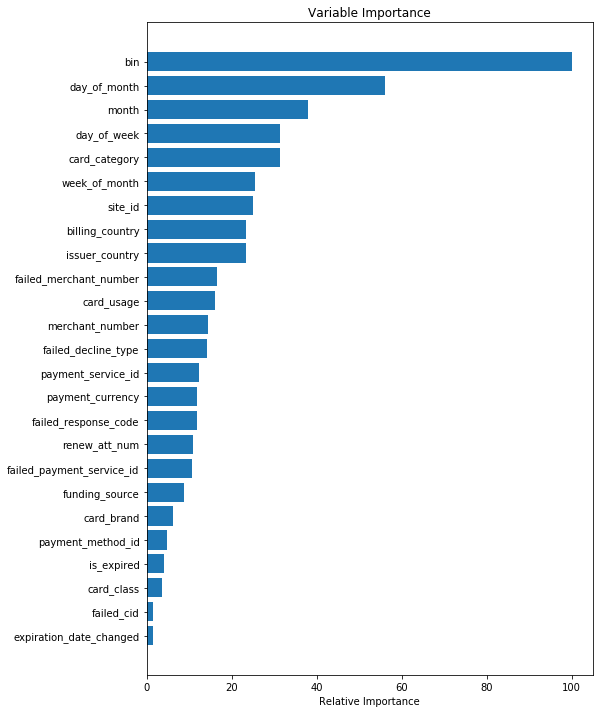

In [32]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 6986
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month']
# fit_time: 190.27262139320374
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month'],
 

/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 6856
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 253
# transform_time: 16339.10326051712
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_servic

[19:33:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[19:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[19:34:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[19:34:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[19:35:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[19:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[19:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[19:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10


[19:56:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[19:57:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[19:57:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[19:57:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[19:58:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[19:58:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[19:58:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[19:59:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10


[20:19:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[20:19:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[20:19:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[20:20:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[20:20:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[20:20:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:21:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:21:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10


[20:41:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:42:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[20:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[20:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[20:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[20:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[20:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[20:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


[21:04:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[21:04:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[21:05:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[21:05:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[21:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[21:06:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[21:06:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[21:06:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[21:27:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[21:27:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[21:27:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[21:27:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[21:28:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[21:28:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[21:28:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[21:29:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10


[21:49:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[21:49:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[21:50:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[21:50:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[21:50:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[21:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[21:51:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[21:51:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10


[22:12:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[22:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[22:13:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[22:13:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[22:13:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[22:14:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[22:14:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[22:14:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10


[22:35:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[22:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[22:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[22:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[22:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[22:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[22:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[22:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10


[22:57:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[22:58:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[22:58:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[22:58:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[22:59:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[22:59:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[22:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[23:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10


[23:20:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[23:21:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[23:21:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:21:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[23:22:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[23:22:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[23:22:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:23:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10


[23:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[23:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[23:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[23:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[23:44:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[23:45:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[23:45:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10


[00:06:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[00:06:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[00:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[00:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[00:08:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[00:08:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[00:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[00:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[00:30:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[00:30:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[00:30:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[00:31:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[00:31:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[00:31:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[00:32:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[00:32:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10


[00:52:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[00:53:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[00:53:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[00:53:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[00:54:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[00:54:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[00:54:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[00:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 28)
x_test (1683437, 24)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9903744503554139
training auc: 0.7805768786177368
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.85      0.56      0.68     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Before applying decline type


/var/spark/jupyter-notebooks/src/web/preprocessing.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After applying decline type ... 2053
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 8
# transform_time: 4521.751228570938
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 66666.23127675056
feature_importance column  Index(['expiration_date_changed', 'failed_cid', 'card_class', 'is_expired',
       'payment_method_id', 'card_brand', 'funding_source',
       'failed_payment_service_id', 'renew_att_num', 'failed_response_code',
       'payment_currency', 'payment_service_id', 'failed_decline_type',
       'merchant_number', 'card_usage', 'failed_merchant_number',
       'issuer_country', 'billing_country', 'site_id', 'week_of_month',
       'card_category', 'day_of_week', 'month', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  1.4058524   1.4535624   3.6895673   4.099872    4.7391853   6.3104324
   8.851781   10.62659    10.890585   11.762086   11.863868   12.344148
  14.112595   14.510179   16.06234    16.53944    23.301527   23.479643
  25.038168   25.613869   31.367683   31.45992    37.875317   56.05916
 100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9874643363547314
test auc: 0.73119717382448

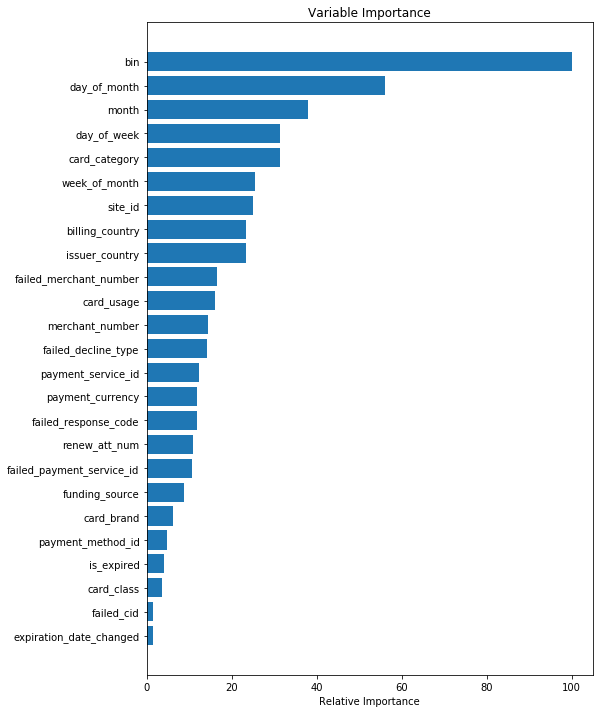

In [32]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


# fit_time: 87.53769540786743
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'payment_currency', 'failed_response_message'],
              drop_invariant=False, handle_unknown='ignore',
              impute_missing=False, random_state=None, randomized=False,
              return_df=True, sigma=0.05, verbose=0)
In transform, self.bin_profile: (32272, 11) 
features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


# transform_time: 15527.45605635643
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.017554              0.017945      0.018597  0.017928   
1        0.018273              0.017945      0.017741  0.018302   
2        0.017679              0.017945      0.018500  0.018225   
3        0.017440              0.017898      0.018183  0.018189   
4        0.019526              0.017945      0.018500  0.019147   

   billing_country  failed_decline_type  merchant_number  payment_s

[06:15:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[06:15:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[06:15:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[06:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[06:16:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[06:16:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[06:17:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[06:17:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10


[06:35:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[06:35:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[06:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[06:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[06:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[06:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[06:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[06:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10


[06:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[06:55:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[06:55:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[06:56:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[06:56:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[06:56:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[06:57:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[06:57:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[07:15:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[07:15:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[07:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[07:16:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[07:16:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[07:16:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[07:17:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[07:17:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10


[07:35:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[07:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10


[07:55:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[07:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[07:55:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[07:55:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[07:56:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[07:56:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[07:56:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[07:57:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10


[08:14:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[08:15:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[08:15:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[08:15:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[08:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[08:16:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[08:16:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[08:16:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10


[08:34:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[08:34:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[08:35:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[08:35:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[08:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[08:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[08:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[08:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10


[08:53:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[08:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[08:54:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[08:54:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[08:54:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[08:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[08:55:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[08:55:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[

[09:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[09:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[09:13:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[09:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[09:13:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[09:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[09:14:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[09:14:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10


[09:31:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[09:31:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[09:32:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[09:32:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[09:32:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[09:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[09:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[09:33:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10


[09:50:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[09:50:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[09:50:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[09:50:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[09:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[09:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[09:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[09:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10


[10:09:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[10:09:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[10:10:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[10:10:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[10:10:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[10:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[10:11:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:11:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10


[10:28:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[10:28:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[10:28:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[10:29:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[10:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[10:29:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[10:29:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[10:30:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10


[10:47:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[10:47:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[10:47:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[10:48:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[10:48:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[10:48:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[10:48:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[10:49:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 20)
x_test (1683437, 20)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9870071316428362
training auc: 0.6778317344249338
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   4959668
          1       0.81      0.36      0.50     90641

avg / total       0.99      0.99      0.98   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


# transform_time: 4305.360013484955
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.017679              0.017945      0.018183  0.017917   
1        0.017652              0.017945      0.017499  0.017917   
2        0.018019              0.018100      0.017536  0.017928   
3        0.018019              0.017772      0.017451  0.017928   
4        0.017679              0.017945      0.018183  0.017917   

   billing_country  failed_decline_type  merchant_number  payment_s

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 39686.83276796341
feature_importance column  Index(['card_class', 'payment_method_id', 'card_brand', 'funding_source',
       'failed_decline_type', 'payment_service_id', 'payment_currency',
       'merchant_number', 'card_usage', 'failed_response_code',
       'issuer_country', 'billing_country', 'site_id', 'card_category',
       'failed_response_message', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  4.489113    4.8564854   7.762612    8.500343   13.500195   13.68836
  13.97509    17.627909   19.745527   24.139063   25.96099    26.534452
  29.509274   33.92969    34.41056    69.956085  100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9850971554029049
test auc: 0.647453170908121
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1653296
          1       0.70      0.30      0.42     30141

avg / total       0.98      0.99      0.98   1683437

# confusion_matrix -  test:
 [[1649

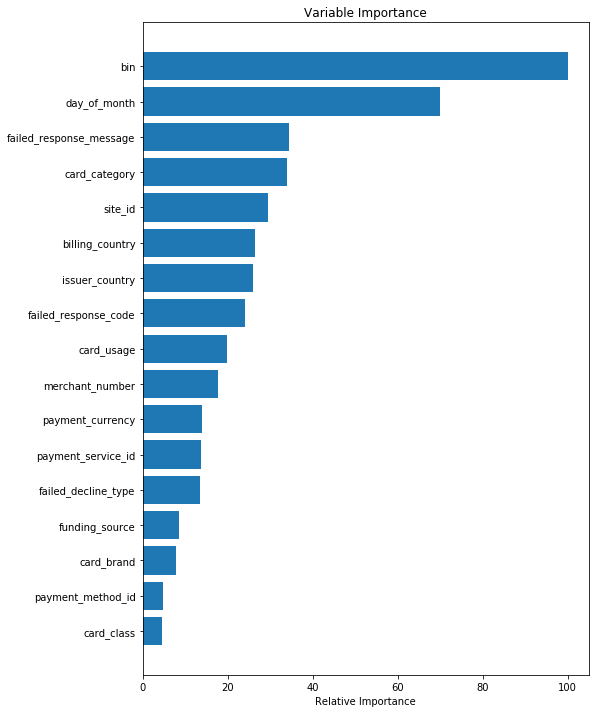

In [23]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month']
# fit_time: 511.43821144104004
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month'],
 

/var/spark/jupyter-notebooks/src/web/preprocessing.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'expiration_date_changed', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

After fillna ...


####### bin_profile: (32272, 11)
df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return df
/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 115.11198878288269
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month'],
              drop_invariant

/var/spark/jupyter-notebooks/src/web/preprocessing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return df
/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

# transform_time: 17719.09565973282
[13:22:59] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:23:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[13:24:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[13:24:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[13:25:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[13:26:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[13:26:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[13:27:16] /workspace/src/tree/updater_pru

[14:01:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[14:01:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[14:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[14:02:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[14:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[14:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[14:04:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[14:05:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10


[14:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[14:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[14:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[14:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[14:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[14:44:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[

[15:17:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[15:18:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[15:18:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[15:19:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[15:19:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[15:20:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[15:21:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[15:21:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10


[15:55:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[15:56:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[15:56:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[15:57:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[15:57:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:58:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[15:58:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[15:59:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10


[16:33:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[16:33:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:34:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:34:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[16:35:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[16:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[16:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10


[17:11:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[17:11:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[17:12:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[17:12:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[17:13:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[17:14:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[17:14:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[17:15:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10


[17:48:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[17:49:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[17:50:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[17:50:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[17:51:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[17:51:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[17:52:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[17:52:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10


[18:26:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[18:27:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[18:28:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[18:28:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[18:29:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[18:29:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[18:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[18:30:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10


[19:05:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[19:06:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[19:06:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[19:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[19:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[19:08:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[19:09:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[19:09:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10


[19:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[19:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[19:44:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[19:45:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[19:45:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[19:46:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[19:47:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[19:47:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10


[20:21:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:22:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[20:22:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[20:23:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[20:23:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[20:24:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[20:25:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[20:25:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10


[21:00:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[21:00:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[21:01:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[21:01:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[21:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[21:02:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[21:03:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[21:04:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10


[21:38:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[21:38:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[21:39:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[21:39:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[21:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[21:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[21:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[21:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10


[22:16:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[22:16:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[22:17:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[22:17:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[22:18:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[22:18:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[22:19:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[22:19:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10


[22:53:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[22:54:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[22:54:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[22:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[22:55:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[22:56:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[22:57:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[22:57:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5053569, 34)
x_test (1684523, 29)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9923487737082446
training auc: 0.8315877645125501
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959865
          1       0.90      0.66      0.76     93704

avg / total       0.99      0.99      0.99   5053569


/var/spark/jupyter-notebooks/src/web/preprocessing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return df
/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

# transform_time: 4565.326989650726


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 65640.7000117302
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'payment_method_id',
       'card_brand', 'funding_source', 'payment_currency',
       'failed_response_code', 'renew_att_num', 'failed_decline_type',
       'card_usage', 'payment_service_id', 'issuer_country', 'billing_country',
       'merchant_number', 'card_category', 'site_id', 'week_of_month',
       'day_of_week', 'Min', 'failed_response_message', 'month', 'Max_95',
       'Min_1', 'Max_99', 'StdDev', 'bin', 'Mean', 'Max', 'day_of_month',
       'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          3.425096    4.4067435   4.796201    5.2656846   6.2313275
   9.800469    9.848485   10.7607765  11.022194   14.041826   14.137858
  14.159198   14.505975   17.066795   23.44217    24.786598   25.72023
  31.802174   33.42936    33.70145    45.92936    49.274433   49.8026
  53.259712   57.0796     57.437046   58.47737    58.509384   59.92318
 100. 

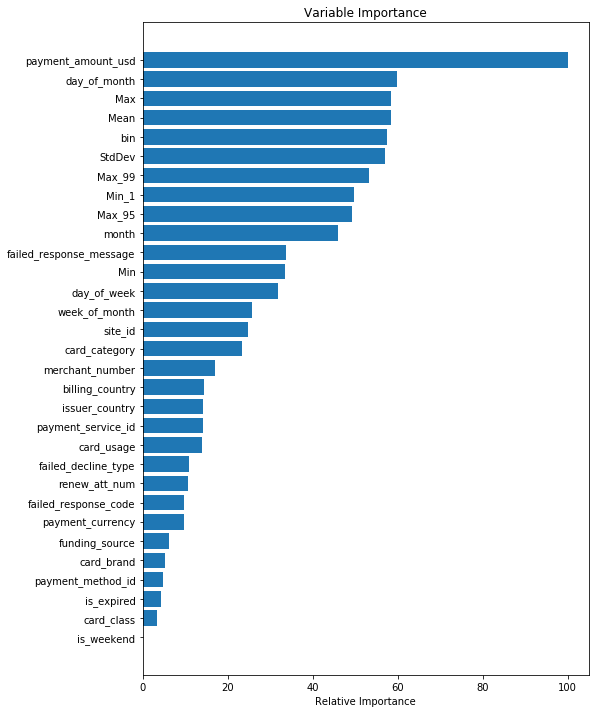

In [25]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 113.73193669319153
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month'],
              drop_invariant

/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

# transform_time: 16587.540313243866
[10:11:13] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:11:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[10:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[10:13:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[10:13:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[10:14:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[10:14:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 0 pruned nodes, max_depth=10
[10:15:23] /workspace/src/tree/updater_pr

[10:48:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[10:48:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[10:49:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[10:50:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[10:50:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[10:51:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[10:51:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[10:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[

[11:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[11:26:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[11:27:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[11:27:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[11:28:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[11:28:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[11:29:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[11:30:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10


[12:04:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[12:05:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[12:05:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[12:06:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[12:07:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[12:07:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[12:08:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[12:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10


[12:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[12:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[12:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[12:44:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[12:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[12:45:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[12:46:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[12:47:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10


[13:20:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[13:21:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[13:22:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[13:22:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[13:23:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[13:23:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[13:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[13:24:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10


[13:58:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[13:59:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[14:00:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[14:00:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[14:01:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[14:01:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[14:02:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[14:03:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10


[14:37:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[14:38:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[14:38:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[14:39:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[14:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[14:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[14:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[14:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10


[15:16:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[15:17:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[15:17:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[15:18:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[15:18:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[15:19:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[15:19:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[15:20:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10


[15:57:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[15:57:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:58:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[15:59:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[15:59:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[16:00:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:00:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:01:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10


[16:35:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[16:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[16:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:37:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[16:38:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[16:39:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[16:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10


[17:13:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[17:14:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[17:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[17:15:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[17:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[17:16:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[17:17:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[17:17:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10


[17:52:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[17:52:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[17:53:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[17:54:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[17:54:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[17:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[17:55:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[17:56:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10


[18:30:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[18:30:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[18:31:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[18:32:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[18:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[18:33:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[18:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:34:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10


[19:09:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[19:09:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[19:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[19:10:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[19:11:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[19:11:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[19:12:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[19:13:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10


[19:47:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[19:48:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[19:49:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[19:49:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[19:50:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[19:50:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[19:51:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[19:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5049885, 34)
x_test (1683296, 29)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9924273523060426
training auc: 0.8274880072791317
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959280
          1       0.89      0.66      0.76     90605

avg / total       0.99      0.99      0.99   5049885


/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

# transform_time: 4585.285441160202


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 63309.87490463257
feature_importance column  Index(['is_weekend', 'card_class', 'payment_method_id', 'card_brand',
       'is_expired', 'funding_source', 'payment_currency',
       'failed_response_code', 'renew_att_num', 'failed_decline_type',
       'payment_service_id', 'card_usage', 'issuer_country', 'billing_country',
       'merchant_number', 'card_category', 'site_id', 'week_of_month', 'Min',
       'day_of_week', 'failed_response_message', 'month', 'Min_1', 'bin',
       'Max_95', 'Max_99', 'StdDev', 'Mean', 'Max', 'day_of_month',
       'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.5075986   3.8855116   5.0455923   5.2279634   5.8611956
   9.407295    9.468085    9.5187435  11.98075    12.06687    13.70314
  14.0070915  14.356635   16.656536   20.759878   23.880445   23.976698
  31.691996   32.02128    32.634243   42.745693   46.266464   49.721375
  49.96454    51.06383    53.652485   54.04762    54.969604   59.959473
 1

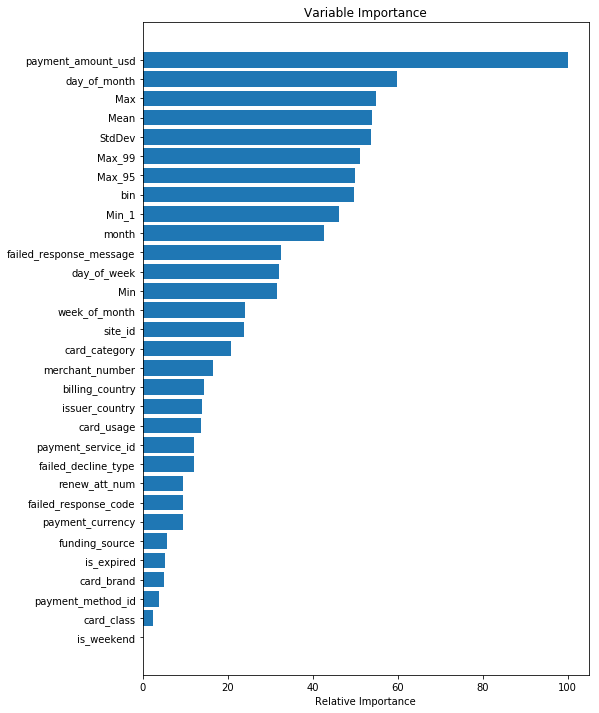

In [41]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
# fit_time: 93.71753644943237
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message'],
              drop_invariant=False, handle_unknown='ignore',
              impute_missing=False, random_state=None, randomized=False,
              return_df=True, sigma=0.05, verbose=0)
In transform, self.bin_profile: (32272, 11) 


/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 16461.300943136215
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017945        0.017830       0.017746    0.017952    0.017966   
1    0.017945        0.017830       0.018031    0.017952    0.017966   
2    0.017945        0.018939       0.018039    0.017952    0.017832   
3    0.017945        0.017830       0.017746    0.017952    0.017966   
4    0.017915        0.018040       0.017908    0.017952    0.018025   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.018448              0.017914      0.018536  0.017850   
1        0.017947              0.018019      0.017880  0.018080   
2        0.018055              0.017914      0.017740  0.018080   
3        0.017918              0.017914      0.018294  0.017917   
4        0.017382              0.017914      0.017155  0.017403   

   billing_country  failed_decline_type  merchant_number  payment_

[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[13:13:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[13:13:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[13:13:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[13:13:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[13:14:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[13:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[13:14:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10


[13:31:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[13:32:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[13:32:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[13:32:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[13:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[13:33:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[13:33:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[13:33:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10


[13:50:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[13:50:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[13:51:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[13:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[13:51:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[13:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[13:52:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[13:52:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10


[14:09:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[14:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[14:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[14:10:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[14:10:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[14:11:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[14:11:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[14:11:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10


[14:28:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[14:29:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[14:29:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[14:29:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[14:29:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[14:30:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[14:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[14:30:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10


[14:47:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[14:48:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[14:48:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[14:48:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[14:49:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[14:49:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[14:49:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[14:49:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10


[15:06:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[15:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[15:07:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[15:07:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[15:07:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[15:08:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[15:08:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[15:08:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10


[15:26:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[15:26:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[15:26:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[15:26:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[15:27:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[15:27:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[15:27:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[15:28:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10


[15:45:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[15:45:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:45:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:45:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[15:46:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[15:46:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[15:46:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[15:47:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10


[16:04:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:04:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10


[16:23:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:23:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[16:23:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[16:24:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:24:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:25:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:25:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[16:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[16:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[16:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:44:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[16:44:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10


[17:01:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[17:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[17:02:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[17:02:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[17:03:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[17:03:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[17:03:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[17:03:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10


[17:20:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[17:21:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[17:21:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[17:21:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[17:22:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[17:22:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[17:22:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[17:22:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10


[17:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[17:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[17:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[17:41:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[17:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[17:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[17:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[17:42:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5049885, 21)
x_test (1683296, 21)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9883177537706305
training auc: 0.7236307520787464
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   4959280
          1       0.82      0.45      0.58     90605

avg / total       0.99      0.99      0.99   5049885


/var/spark/jupyter-notebooks/src/web/preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)


features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/var/spark/jupyter-notebooks/src/web/preprocessing.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = df[BIN].astype(str).str.replace('.0', '', regex=False)


# transform_time: 4488.765804767609
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017945         0.01804       0.018155    0.017952    0.018025   
1    0.017945         0.01783       0.017688    0.017952    0.017966   
2    0.017915         0.01783       0.018639    0.017952    0.017832   
3    0.017915         0.01783       0.017770    0.017952    0.017966   
4    0.017945         0.01783       0.018031    0.017952    0.017966   

   issuer_country  failed_response_code  day_of_month   site_id  \
0        0.018289              0.017914      0.018108  0.018004   
1        0.017918              0.017914      0.017895  0.017917   
2        0.017754              0.018148      0.018108  0.018004   
3        0.018954              0.018019      0.017784  0.018080   
4        0.017947              0.018019      0.017892  0.018004   

   billing_country  failed_decline_type  merchant_number  payment_s

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 41914.776153087616
feature_importance column  Index(['card_class', 'payment_method_id', 'card_brand', 'funding_source',
       'renew_att_num', 'failed_decline_type', 'payment_service_id',
       'failed_response_code', 'payment_currency', 'merchant_number',
       'card_usage', 'billing_country', 'issuer_country', 'site_id',
       'card_category', 'failed_response_message', 'day_of_month', 'bin'],
      dtype='object')
feature_importance val  [  4.0113044   4.4215517   7.202115    8.964658    9.65448    11.474762
  11.888048   12.140273   13.5290365  17.263803   17.996172   24.520618
  24.882244   26.368248   31.807821   33.09934    62.782997  100.       ]
accuracy_dummy: 0.9821308908237173
test accuracy: 0.9866321787730737
test auc: 0.6929307973294186
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1653217
          1       0.74      0.39      0.51     30079

avg / total       0.98      0.99      0.98   1683296

# c

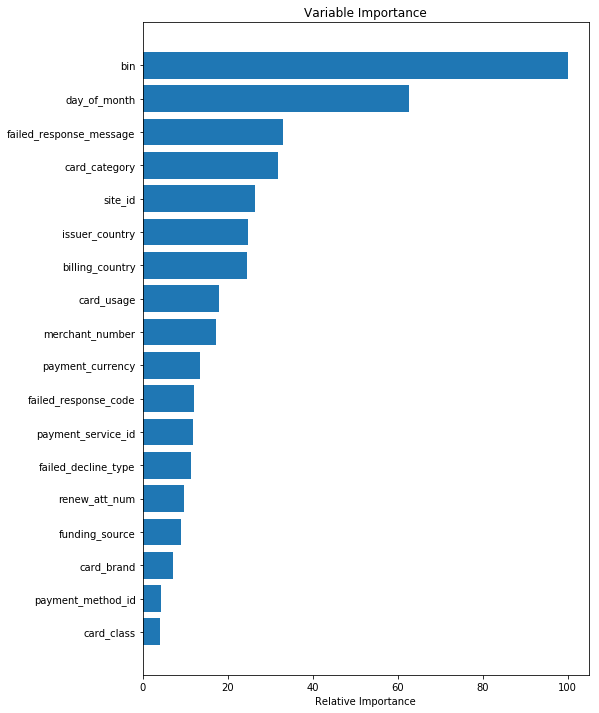

In [124]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [131]:
retry_success['failed_decline_type'].value_counts()

txn_refused                   2422853
do_not_honor                  1061354
declined                      1038845
Insufficient Funds             992370
Hard Fraud                     485393
Base                           243081
not_allowed                    134881
expired_card                   131055
correct_cc_retry                86594
invalid_cc                      37547
do_not_try                      33623
invalid_txn                     20159
blocked_first_used              18052
system error                    15858
not_permitted                    6138
invalid_account                  3810
unable to determine format       1283
attempt_lower_amount              137
Stop Recurring                    136
restricted_card                    12
Name: failed_decline_type, dtype: int64

In [94]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success[:1000], classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


KeyError: "['failed_attempt_date'] not in index"

In [38]:
PAY_AMOUNT_USD = 'payment_amount_usd'
retry_success['mean_diff'] = retry_success['Mean'] - retry_success[PAY_AMOUNT_USD]
retry_success['median_diff'] = retry_success['Median'] - retry_success[PAY_AMOUNT_USD]
# retry_success['max_95_diff'] = retry_success['Max_95'] - retry_success[PAY_AMOUNT_USD]
retry_success['max_99_diff'] = retry_success['Max_99'] - retry_success[PAY_AMOUNT_USD]
retry_success['std_diff'] = retry_success['StdDev'] - abs(retry_success['mean_diff']) 
retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_response_code,failed_response_message,failed_decline_type,failed_event_uuid,failed_cc_expiration_date,expiration_date_changed,processor_mid_changed,failed_cid,failed_payment_service_id,failed_merchant_number,processor_att_num,mean_diff,median_diff,max_99_diff,std_diff,Mean,Median,Min,Max,StdDev,Max_95,Max_99,Min_1
0,0,2019-02-03,avast,10007475401,8230718493,2019-02-03 14:38:20,2.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0420,RETRY_DECLINED.2,2.0,3,sunday,af5fedf6-62f6-489c-8fea-4a72b5c2e97b,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,114.700000,EUR,MasterCard,netgiro-bms,1,99.99,114.700000,EUR,57531456100,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-03 08:38:20,8,Authorize,0,530.0,Refused: Refused,txn_refused,d9683bf6-9d95-416e-9e46-a02a7b237bb0,0420,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2,-53.808010,-55.361870,-0.515664,-33.034194,60.891990,59.338130,2.27,271.599654,20.773815,94.172227,114.184336,41.146491
1,1,2019-02-08,avast,10007475401,8258737853,2019-02-08 12:15:40,0.0,NON3DS,CREDIT AGRICOLE S.A.,FR,513770,MasterCard,MasterCard Standard (Unembossed) Card Immediate Debit,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0418,RETRY_DECLINED.2,0.0,8,friday,840199bd-00a6-426d-aa44-e4a155f48067,1872543.0,Debit,FR,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,99.99,113.440000,EUR,MasterCard,netgiro-bms,2,99.99,113.440000,EUR,57730537600,27050.0,Do not try again/use alternate payment card.[62] [] [111800] [111800],New,13274386200,2019-02-08 06:15:40,6,Authorize,0,522.0,05: Do not honor,do_not_honor,efae77a9-9eba-47eb-8200-d3d235f2424a,0418,False,processor_changed_mid_changed,NaN,adyen,DR_IRELAND,2,-52.548010,-54.101870,0.744336,-31.774194,60.891990,59.338130,2.27,271.599654,20.773815,94.172227,114.184336,41.146491
2,2,2019-03-07,adbehkr,10059085901,8421456683,2019-03-07 06:41:52,NaN,NON3DS,"HYUNDAICARD CO., LTD.",KR,552290,MasterCard,World MasterCard Card,Consumer,Credit - True credit (No PIN/Signature capability),0922,RETRY_DECLINED.2,NaN,7,thursday,ade6ea11-11c1-4d9a-9e52-60bc4ed4c6fd,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.800000,KRW,MasterCard,netgiro-bms,1,11000.00,9.800000,KRW,58876377200,27050.0,Do not try again/use alternate payment card.[62] [] [144800] [144800],New,18805274000,2019-03-07 00:41:52,0,Authorize,0,27001.0,Transaction refused[62] [000000] [] [],Hard Fraud,27c2e03c-15c5-4b43-a222-c40f65023c1f,0922,False,processor_changed_mid_changed,NaN,netgiro-seb,1156962062,2,13.911859,10.642493,46.043974,15.873344,23.711859,20.442493,4.80,1547.411901,29.785203,54.788050,55.843974,9.788554
3,3,2019-01-11,adbehkr,10076134701,8095353453,2019-01-11 06:40:54,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,451842,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0221,RETRY_DECLINED.2,NaN,11,friday,ce3cb7bb-0bdc-4552-9485-fb2f978cd68b,NaN,Credit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.843372,KRW,Visa,netgiro-bms,1,11000.00,9.843372,KRW,56551670600,27001.0,Transaction

In [18]:
# retry_success.to_csv(WORK_DIR + 'processor_retry__2018_01_to_2019_02.csv')

In [ ]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (38193, 12)
# df_bin_profile: (38193, 12)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'processor_att_num', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'StdDev', 'Max_99', 'Median', 'mean_diff', 'max_99_diff', 'std_diff', 'median_diff']
# fit_time: 28.861626386642456
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'fa

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [46]:
result_d

{'training_time': 14341.635489463806,
 'accuracy_dummy': 0.9834486616391812,
 'train_accuracy': 0.9959448550002521,
 'test_accuracy': 0.9882675892931134,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       1.00      1.00      1.00   1423765\n          1       0.93      0.82      0.87     24272\n\navg / total       1.00      1.00      1.00   1448037\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99    474691\n          1       0.71      0.50      0.59      7989\n\navg / total       0.99      0.99      0.99    482680\n',
 'train_auc': 0.9091878685225864,
 'test_auc': 0.7483963727847509,
 'conf_mx': [[473020, 1671], [3992, 3997]]}

####### bin_profile: (38193, 12)
# df_bin_profile: (38193, 12)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'processor_mid_changed', 'expiration_date_changed', 'processor_att_num', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'Median', 'mean_diff', 'max_99_diff', 'std_diff', 'median_diff']
# fit_time: 29.18586301803589
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'paymen

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


# transform_time: 4568.967654705048
[04:04:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[04:04:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[04:04:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[04:04:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[04:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[04:04:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[04:04:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[04:05:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra 

[04:13:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[04:13:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[04:14:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[04:14:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[04:14:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[04:14:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:14:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[04:14:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[

[04:23:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[04:23:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[04:23:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[04:23:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[04:24:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[04:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[04:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[04:24:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[

[04:33:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[04:33:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[04:33:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[04:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:33:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[04:33:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[04:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[04:34:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[

[04:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[04:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[04:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[04:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[04:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[04:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[04:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[04:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10


[04:52:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[04:52:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[04:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[04:52:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[04:53:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[04:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[04:53:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[04:53:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10


[05:02:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[05:02:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[05:02:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[05:02:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[05:02:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[05:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[05:03:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[05:03:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10


[05:11:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[05:12:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[05:12:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[05:12:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[05:12:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[05:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[05:12:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[05:13:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10


[05:21:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[05:21:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[05:21:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[05:22:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[05:22:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[05:22:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[05:22:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[05:22:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[

[05:31:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[05:31:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[05:31:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[05:32:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[05:32:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[05:32:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[05:32:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[05:32:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10


[05:41:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[05:41:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[05:41:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[05:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[05:41:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[05:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[05:42:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[05:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10


[05:51:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[05:51:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[05:51:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[05:51:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[05:51:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[05:52:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[05:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[05:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10


[06:01:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[06:01:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[06:01:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[06:01:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[06:01:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[06:01:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[06:02:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[06:02:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10


[06:11:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[06:11:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[06:11:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[06:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[06:11:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[06:11:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[06:11:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[06:12:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[

[06:20:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[06:20:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[06:21:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[06:21:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[06:21:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[06:21:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[06:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[06:21:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10


[06:30:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[06:30:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[06:30:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[06:31:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[06:31:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[06:31:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[06:31:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[06:31:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1448037, 45)
x_test (482680, 41)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9961326955043276
training auc: 0.913900090451473
             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1423765
          1       0.93      0.83      0.88     24272

avg / total       1.00      1.00      1.00   1448037

I

/var/spark/jupyter-notebooks/src/web/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


# transform_time: 1322.7372889518738


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 15748.188497781754
feature_importance column  Index(['processor_mid_changed', 'expiration_date_changed', 'processor_att_num',
       'failed_cid', 'card_class', 'payment_method_id', 'is_expired',
       'card_brand', 'funding_source', 'payment_currency',
       'failed_payment_service_id', 'payment_service_id',
       'failed_response_code', 'renew_att_num', 'failed_decline_type', 'month',
       'issuer_country', 'billing_country', 'card_usage', 'site_id',
       'merchant_number', 'card_category', 'failed_merchant_number',
       'week_of_month', 'bank_code', 'day_of_week', 'Min', 'Max_95', 'Median',
       'Max_99', 'Mean', 'StdDev', 'Min_1', 'bin', 'Max', 'day_of_month',
       'payment_amount_usd', 'mean_diff', 'median_diff', 'max_99_diff',
       'std_diff'],
      dtype='object')
feature_importance val  [  0.           0.12795906   0.38387716   0.8189379    2.2648754
   4.427383     5.310301     5.732566     7.2552786    9.763276
  12.143314    13.742802    13.8

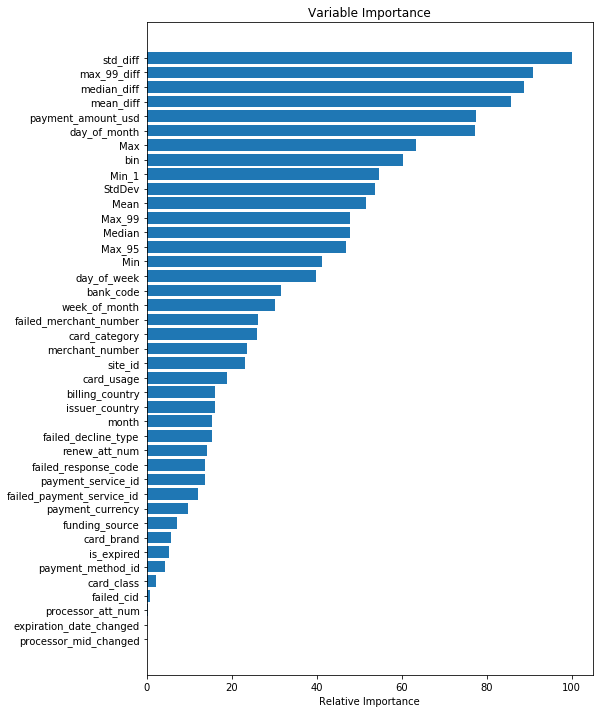

In [40]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'week_of_month', 'day_of_week', 'is_expired', 'month', 'payment_amount_usd']
# fit_time: 608.606942653656
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'day_of_month', 'failed_cid', 'failed_payment_service_id', 'failed_merchant_number', 'failed_response_code', 'bank_code', 'week_of_month', 'day_of_week', 'is_expired', 'month'],
         

/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 135
# transform_time: 24815.56042075157
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_servic

[18:15:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[18:15:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[18:15:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[18:16:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[18:16:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[18:17:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[18:17:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[18:17:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10


[18:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[18:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[18:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[18:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[18:43:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[18:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[18:44:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[18:44:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10


[19:08:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[19:09:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[19:09:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[19:10:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[19:10:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[19:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[19:11:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[19:11:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10


[19:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[19:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[19:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[19:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[19:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[19:37:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[19:38:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[19:38:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10


[20:02:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[20:03:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:03:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[20:04:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[20:04:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[20:05:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[20:05:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10


[20:29:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:30:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[20:30:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[20:31:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[20:31:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[20:31:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[20:32:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[20:32:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[

[20:57:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[20:57:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[20:57:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:58:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[20:58:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:59:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[20:59:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[20:59:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10


[21:24:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[21:24:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[21:25:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[21:25:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[21:25:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[21:26:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[21:26:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[21:27:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[21:51:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[21:52:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[21:52:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[21:52:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[21:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[21:53:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[21:54:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[21:54:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10


[22:18:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[22:19:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[22:19:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[22:19:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[22:20:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[22:20:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[22:21:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[22:21:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10


[22:46:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[22:46:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[22:46:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[22:47:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[22:47:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[22:48:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[22:48:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[22:48:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10


[23:13:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[23:13:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[23:13:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[23:14:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[23:14:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[23:15:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[23:15:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[23:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10


[23:40:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[23:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[23:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[23:41:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[23:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[23:42:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[23:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[23:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[

[00:07:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[00:08:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[00:08:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[00:08:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[00:09:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[00:09:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[00:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[00:10:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10


[00:34:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[00:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[00:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[00:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[00:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[00:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[00:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[00:37:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 29)
x_test (1683437, 25)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9908175915572691
training auc: 0.7859580110264974
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.87      0.57      0.69     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pd.merge(df, self.bin_profile[[BIN] + self.features_num_encoded], left_on=BIN, right_on=BIN, how='left')


Before fillna ...


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


After fillna ... 8
# transform_time: 6500.527398109436
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017829   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 64170.62037587166
feature_importance column  Index(['failed_cid', 'card_class', 'is_expired', 'payment_method_id',
       'card_brand', 'funding_source', 'failed_payment_service_id',
       'renew_att_num', 'payment_currency', 'failed_response_code',
       'payment_service_id', 'failed_decline_type', 'merchant_number',
       'failed_merchant_number', 'card_usage', 'issuer_country',
       'billing_country', 'site_id', 'week_of_month', 'day_of_week',
       'card_category', 'month', 'day_of_month', 'bank_code',
       'payment_amount_usd', 'bin'],
      dtype='object')
feature_importance val  [  1.2856805   3.5189118   4.2187624   4.5883465   6.322246    8.119054
   9.632774   10.11638    10.395534   10.780845   10.820162   13.391523
  13.690336   14.519935   15.168672   19.878902   20.445074   21.51451
  22.910278   26.291578   31.088308   37.51278    49.005272   50.85712
  96.2963    100.       ]
accuracy_dummy: 0.9820955580755324
test accuracy: 0.9871584146006058
t

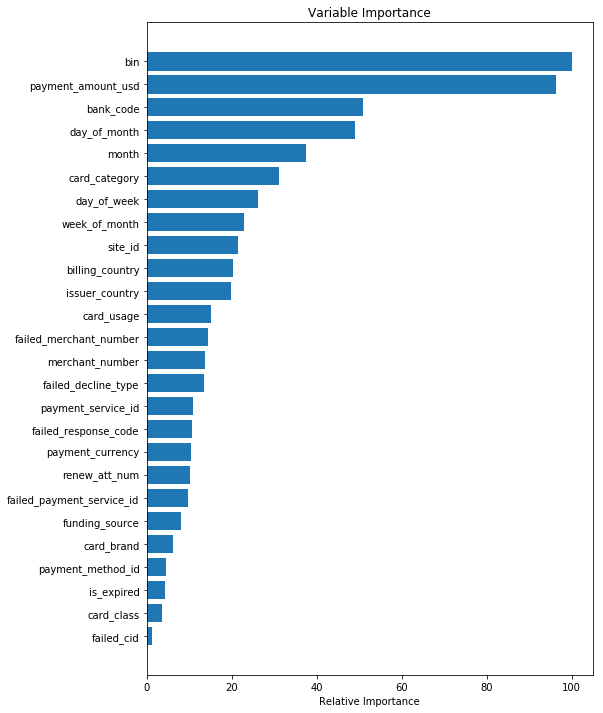

In [49]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


####### bin_profile: (32272, 11)
# df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'mean_diff', 'max_99_diff', 'std_diff']
# fit_time: 110.69572973251343
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month'],
              drop

/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


# transform_time: 14709.858207941055
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017995        0.018056       0.017465    0.017956    0.017846   
1    0.017909        0.017910       0.018029    0.018592    0.018075   
2    0.017909        0.017910       0.017713    0.017993    0.018075   
3    0.017995        0.018056       0.017957    0.017956    0.018054   
4    0.017995        0.017910       0.018158    0.017993    0.017820   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017554  0.017928         0.017747             0.017973   
1        0.018273  0.018302         0.018235             0.017869   
2        0.017679  0.018225         0.017638             0.017973   
3        0.017440  0.018189         0.017483             0.017973   
4        0.019526  0.019147         0.019476             0.017973   

   merchant_number  payment_service_id  payment_method

[15:08:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[15:09:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:10:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[15:10:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[15:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[15:12:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[15:12:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[15:13:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10


[15:54:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[15:54:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[15:55:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[15:56:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[15:56:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[15:57:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[15:58:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[15:59:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10


[16:40:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[16:44:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10


[17:24:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[17:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[17:25:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[17:26:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[17:27:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[17:28:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[17:28:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[17:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10


[18:09:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[18:10:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[18:11:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[18:11:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[18:12:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:13:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[18:13:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[18:14:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10


[18:54:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[18:55:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[18:56:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[18:56:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[18:57:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[18:58:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[18:58:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:59:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10


[19:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[19:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[19:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[19:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[19:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[19:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[19:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[19:44:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10


[20:24:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[20:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[20:25:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:26:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[20:27:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[20:27:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[20:28:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[20:29:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10


[21:09:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[21:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[21:10:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[21:11:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[21:12:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[21:13:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[21:13:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[21:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


[21:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[21:55:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[21:56:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[21:57:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[21:57:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[21:58:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[21:59:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[21:59:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10


[22:39:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[22:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[22:40:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[22:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[22:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[22:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[22:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[22:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10


[23:21:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[23:22:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[23:23:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[23:23:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[23:24:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[23:25:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[23:25:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[23:26:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10


[00:07:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[00:08:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[00:08:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[00:09:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[00:10:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[00:11:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[00:11:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[00:12:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10


[00:51:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[00:52:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[00:53:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[00:54:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[00:54:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[00:55:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[00:55:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[00:56:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10


[01:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[01:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[01:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[01:37:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[01:38:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[01:38:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[01:39:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[01:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5050309, 36)
x_test (1683437, 31)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9923032432272956
training auc: 0.8254944805133161
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959668
          1       0.89      0.65      0.75     90641

avg / total       0.99      0.99      0.99   5050309


/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'processor_mid_changed', 'expiration_date_changed', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month']
Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')


# transform_time: 4320.516642808914
Transforming ...
Finish transforming.
df_encoded_all: .....     card_brand  funding_source  card_category  card_class  card_usage  \
0    0.017909        0.018056       0.017409    0.017956    0.017846   
1    0.017995        0.017910       0.017922    0.017956    0.018075   
2    0.017995        0.017910       0.018197    0.017956    0.017820   
3    0.017995        0.017910       0.018197    0.017956    0.017820   
4    0.017909        0.018056       0.017409    0.017956    0.018054   

   issuer_country   site_id  billing_country  failed_decline_type  \
0        0.017679  0.017917         0.017638             0.017973   
1        0.017652  0.017917         0.017696             0.018018   
2        0.018019  0.017928         0.017996             0.017834   
3        0.018019  0.017928         0.017996             0.017892   
4        0.017679  0.017917         0.017638             0.018018   

   merchant_number  payment_service_id  payment_method_

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 125867.01251196861
feature_importance column  Index(['is_weekend', 'processor_mid_changed', 'expiration_date_changed',
       'card_class', 'payment_method_id', 'is_expired', 'card_brand',
       'funding_source', 'payment_currency', 'renew_att_num', 'card_usage',
       'issuer_country', 'billing_country', 'payment_service_id',
       'merchant_number', 'failed_decline_type', 'card_category', 'site_id',
       'week_of_month', 'Min', 'day_of_week', 'Max_99', 'Max_95', 'Min_1',
       'month', 'StdDev', 'Max', 'Mean', 'bin', 'payment_amount_usd',
       'max_99_diff', 'mean_diff', 'std_diff'],
      dtype='object')
feature_importance val  [0.0000000e+00 7.5165359e-03 1.9092001e+00 3.2321107e+00 5.6749845e+00
 6.3063731e+00 7.3211064e+00 7.6894164e+00 1.2139206e+01 1.4025857e+01
 1.8415514e+01 1.8821407e+01 1.9249849e+01 1.9843657e+01 2.1873121e+01
 2.5157845e+01 2.8119362e+01 2.8773302e+01 3.5312687e+01 3.5898975e+01
 3.9935356e+01 5.0909500e+01 5.4652740e+01 5.4968430

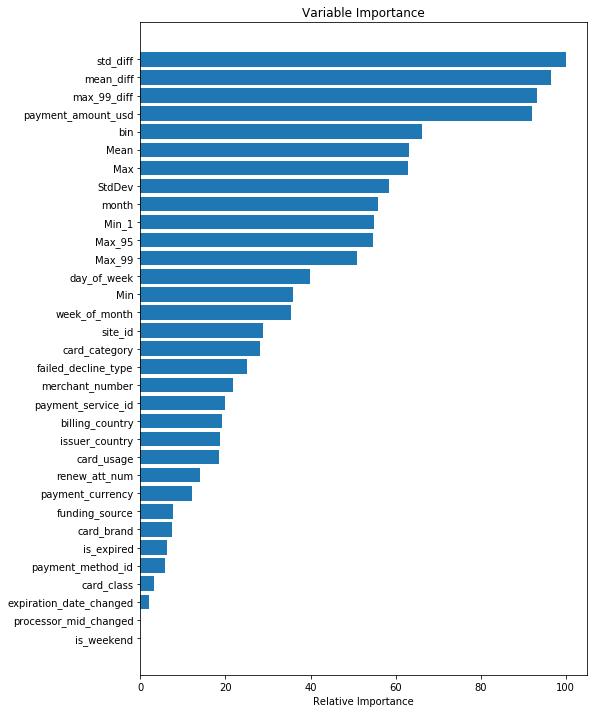

In [18]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
result_d

####### bin_profile: (32272, 11)
df_bin_profile: (32272, 11)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...


/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'transaction_hour', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'month', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 119.87449240684509
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'payment_currency', 'failed_response_message', 'transaction_hour', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired'

/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

# transform_time: 16811.96008872986
[09:59:58] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:00:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[10:01:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[10:02:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[10:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[10:03:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[10:03:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[10:04:36] /workspace/src/tree/updater_pru

[10:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[10:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[10:41:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[10:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[10:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[10:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[10:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[10:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10


[11:20:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[11:21:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[11:21:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[11:22:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[11:23:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[11:23:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[11:24:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[11:24:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[1

[12:00:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[12:01:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[12:01:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[12:02:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[12:03:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[12:03:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[12:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[12:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10


[12:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[12:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[12:41:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[12:42:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[12:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[12:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[12:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[12:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[

[13:21:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[13:21:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[13:22:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[13:22:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[13:23:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[13:24:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[13:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[13:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10


[14:01:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[14:01:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[14:02:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[14:03:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[14:04:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[14:04:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[14:05:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10


[14:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[14:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[14:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[14:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[14:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[14:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[14:44:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[14:45:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10


[15:21:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[15:22:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[15:22:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[15:23:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[15:24:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[15:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[15:25:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10


[16:02:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[16:03:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[16:04:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:06:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[16:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10


[16:43:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[16:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[16:44:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[16:45:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:46:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:46:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[16:47:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:47:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10


[17:24:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[17:24:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[17:25:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[17:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[17:26:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[17:27:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[17:27:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[17:28:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10


[18:05:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[18:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[18:06:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[18:07:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[18:07:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[18:08:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[18:09:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[18:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10


[18:45:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[18:46:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[18:47:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[18:47:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[18:48:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[18:49:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[18:49:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[18:50:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10


[19:25:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[19:26:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[19:26:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[19:27:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[19:28:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[19:28:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[19:29:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[19:30:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10


[20:07:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[20:07:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[20:08:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[20:09:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[20:09:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[20:10:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[20:10:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[20:11:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (5049885, 35)
x_test (1683296, 30)
pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9926740905981027
training auc: 0.8330095979600586
             precision    recall  f1-score   support

          0       0.99      1.00      1.00   4959280
          1       0.90      0.67      0.77     90605

avg / total       0.99      0.99      0.99   5049885


/var/spark/jupyter-notebooks/src/web/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var/spark/jupyter-notebooks/src/web/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/var

# transform_time: 4640.496551990509


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 65440.99902653694
feature_importance column  Index(['is_weekend', 'card_class', 'payment_method_id', 'card_brand',
       'is_expired', 'funding_source', 'payment_currency', 'renew_att_num',
       'failed_response_code', 'failed_decline_type', 'payment_service_id',
       'card_usage', 'billing_country', 'issuer_country', 'merchant_number',
       'site_id', 'card_category', 'week_of_month', 'transaction_hour',
       'day_of_week', 'Min', 'failed_response_message', 'month', 'Min_1',
       'Max_95', 'Max_99', 'bin', 'StdDev', 'Mean', 'Max', 'day_of_month',
       'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.580269    3.9207377   5.208223    5.2982936   6.1513195
   9.56342     9.897213    9.907809   12.270848   12.29734    14.220621
  14.512028   14.882909   16.684328   22.70319    23.286001   26.17887
  26.984211   30.041325   31.106285   33.114334   42.582386   46.132244
  51.653065   51.917984   53.830666   54.19625    54.4

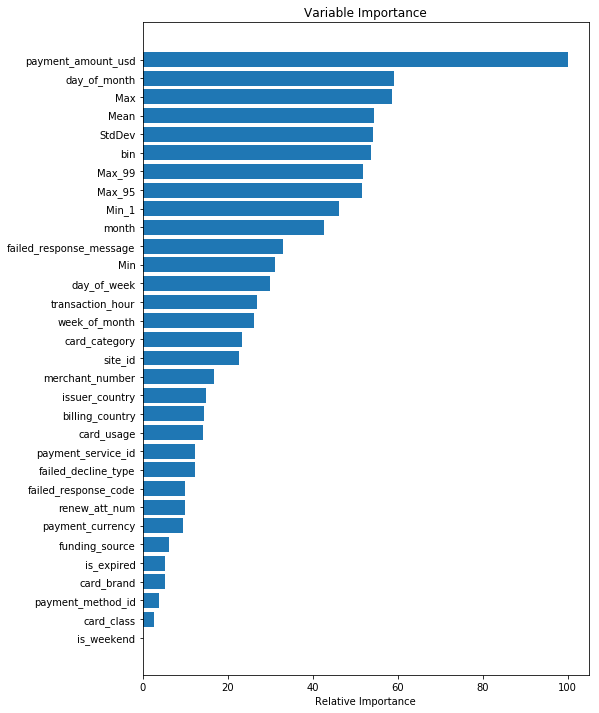

In [47]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[6],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BPR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [42]:
retry_success['days_between'].value_counts()

0    6733181
Name: days_between, dtype: int64

In [22]:
PREPROCESS_DIR = 'src/web/'

def handle_preprocessing_file(model_id, version) :
    from shutil import copyfile
    preprocess_file_name = '{}_{}_preprocessing.py'.format(model_id, version)
    preprocess_file_path = PREPROCESS_DIR + preprocess_file_name
    copyfile(PREPROCESS_DIR + "preprocessing.py", preprocess_file_path)
    repo_path = upload_artifact(preprocess_file_path)
    return repo_path
    
# preprocess_repo_path = handle_preprocessing_file(model_id, version) 
# preprocess_repo_path

In [47]:
"""Upload model to Nexus repo and insert the model info into Cassandra table"""
import json

repo_path = upload_artifact(model_file_name)
preprocess_repo_path = handle_preprocessing_file(model_id, version) 
size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
desc = '%s_%s_for_processor_retry'.format(start_date, end_date) + size_desc
hyper_params = result_d.pop('hyper_params', None)
extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
insert_model_info(model_id, version, repo_path, desc=desc, eval_metrics=json.dumps(result_d), 
                  hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att))

http://nexus.digitalriverws.net/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BPR/1.19/ML-BPR-1.19.pkl
[com.digitalriver.prediction-service:ML-BPR:1.19::pkl]
http://nexus.digitalriverws.net/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BPR/1_19_preprocessing/ML-BPR-1_19_preprocessing.py
[com.digitalriver.prediction-service:ML-BPR:1_19_preprocessing::py]
Model ML-BPR-1 version 19 is inserted into model repo


The following files were uploaded to repository foundationreleases
The following files were uploaded to repository foundationreleases


In [44]:
retry_success['is_country_equal'] = retry_success['issuer_country'] == retry_success['billing_country']

In [19]:
retry_success_new_card = retry_success[(retry_success['added_expiry_years'].isna()) & (retry_success['expiration_date_changed'] == True)]

In [21]:
retry_success['success'].value_counts(normalize=True)

0    0.983291
1    0.016709
Name: success, dtype: float64

In [20]:
retry_success_new_card['success'].value_counts(normalize=True)

0    0.936795
1    0.063205
Name: success, dtype: float64

In [29]:
gp = retry_success_new_card.groupby(['site_id'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 1]

success       success_rate
             sum count             
site_id                            
avast          6     9    66.666667
kasperus       2     4    50.000000
avgstore      73  1313     5.559787

In [24]:
retry_success['processor_att_num'].value_counts(dropna=False)

 2    1825150
 3     105272
 4        226
-1         35
 5         34
Name: processor_att_num, dtype: int64

In [31]:
gp = retry_success.groupby(['site_id'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['success_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')] * 100

df_gp = df_gp.sort_values(by=['success_rate',('success', 'count')], ascending=False)
df_gp[df_gp[('success', 'count')] > 1000]

success         success_rate
             sum   count             
site_id                              
cppro       1087    8912    12.197038
logib2c       90    1068     8.426966
adsk         140    2392     5.852843
flickr       250    4418     5.658669
adbeheu     3383   60976     5.548084
ciscoctg      79    2060     3.834951
adbehap     6468  191162     3.383518
defendde      93    3325     2.796992
tmamer       775   31224     2.482065
kasperla     140    6353     2.203683
kaspernl      67    3754     1.784763
avast       7714  521641     1.478795
kasper       585   40791     1.434140
avgstore    8059  597334     1.349161
kasperus    1436  111388     1.289187
kaspersk      55    4518     1.217353
kasperuk     118   11259     1.048050
adbehil      133   13339     0.997076
kaspergl      16    2049     0.780869
tmapac        70    9924     0.705361
tmecon        38    5809     0.654157
defendes       7    1110     0.630631
adbehkr      601  113939     0.527475
tmemea        19    4174     0.455199
adbehme      154   43218     0.356333
avastbr      269   78883     0.341011
adbehru       84   34107     0.246284
kasperde      18   10436     0.172480
kasucpru       1    2664     0.037538

In [52]:
result_d['test_class_report']

'             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99   1653296\n          1       0.73      0.45      0.56     30141\n\navg / total       0.99      0.99      0.99   1683437\n'

In [ ]:
retry_success

In [35]:
list(range(-1, 5)) + ["STALE"]

[-1, 0, 1, 2, 3, 4, 'STALE']